# Paper Replication
### “Eureka, a version of Momentum that Works in Japan" by Denis Chaves

## Content Table

1. [Build the signal](#bullet_1)
1. [Build Portfolios](#bullet_2)
1. [Summary](#bullet_3)
1. [Size Analysis](#bullet_4)
1. [IUMD Factor](#bullet_5)
1. [Performence After Formation](#bullet_6)
1. [5 Factor Idiosyncratic Momentum](#bullet_7)



## Bookmarks

* [Table 1: WML Portfolios](#table_1)
* [Table 2: WML Portfolios Factor Regressions](#table_2)
* [Table 3: WML Portfolios in Size Groups](#table_3)
* [Table 5: Excess Returns and Factor Loadings](#table_5)
* [Table 6: Spanning Tests](#table_6)
* [Table 7: UMD Extreme Months](#table_7)
* [Table 8.1: Five-factor IMOM Summary](#table_8.1)
* [Table 8.2: Five-factor IMOM Factor Regressions](#table_8.2)


* [Figure 1: Average returns](#figure_1)
* [Figure 2: Four factor alphas](#figure_2)
* [Figure 2.1: Five-factor alphas](#figure_2.1)
* [Figure 3: Cumulative performance](#figure_3)
* [Figure 4.1: Five-factor IMOM P/L Curve](#figure_4.1)
* [Figure 4.2: Five-factor IMOM Cumulative performance](#figure_4.2)



# 1. Build the signal <a class="anchor" id="bullet_1"></a>

In [1]:
options(repr.plot.width=15, repr.plot.height=10)

In [2]:
options(warn=-1)

require(RMySQL)  # for retreiving data
require(data.table)  # read in pandas-type data frame
require(dplyr)  # for syntax
require(feather) # to read in feather files
require(ggplot2) # for making pretty graphs
require(RcppRoll) # for creating lag/rolling
require(lubridate) # for manipulating dates
require(rollRegres) # for rolling regression
require(stargazer) # for fancy tables

options(warn=0)

Loading required package: RMySQL

Loading required package: DBI

Loading required package: data.table

Loading required package: dplyr


Attaching package: 'dplyr'


The following objects are masked from 'package:data.table':

    between, first, last


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


Loading required package: feather

Loading required package: ggplot2

Loading required package: RcppRoll

Loading required package: lubridate


Attaching package: 'lubridate'


The following objects are masked from 'package:dplyr':

    intersect, setdiff, union


The following objects are masked from 'package:data.table':

    hour, isoweek, mday, minute, month, quarter, second, wday, week,
    yday, year


The following objects are masked from 'package:base':

    date, intersect, setdiff, union


Loading required package: rollRegres

Loading required package: starga

## 1.1 Load Data

In [3]:
#Load Data
con_server = dbConnect(
    MySQL(),
    host = "apkwan.cqs7w8sr4z03.ap-east-1.rds.amazonaws.com",
    user = "leung_chak",
    password = "ac06ec",
    dbname = "temp_leung_chak"
)

data.path = "G:/My Drive/Archive/Data/data_for_quant_trading/feather/"

crsp_msf = read_feather(paste0(data.path,"crsp_msf.feather"))
dsenames = read_feather(paste0(data.path,"dsenames.feather"))

msf = read_feather(paste0(data.path,'msf_delisting_adjusted.feather'))
chaves_betas = read_feather(paste0(data.path,"chaves_betas.feather"))

ff_four = read_feather(paste0(data.path,"ff_four_factor_monthly.feather"))
ff_five = dbGetQuery(con_server, "SELECT * from ff.five_factor_monthly")

setDT(crsp_msf)
setkey(crsp_msf, permno, date)

setDT(dsenames)
setkey(crsp_msf, permno)

setDT(msf)

setDT(chaves_betas)
setkey(chaves_betas, permno, end_of_estimation_window)

setDT(ff_four)
setDT(ff_five)


dbDisconnect(con_server)

Warning message in .local(conn, statement, ...):
"Decimal MySQL column 1 imported as numeric"
Warning message in .local(conn, statement, ...):
"Decimal MySQL column 2 imported as numeric"
Warning message in .local(conn, statement, ...):
"Decimal MySQL column 3 imported as numeric"
Warning message in .local(conn, statement, ...):
"Decimal MySQL column 4 imported as numeric"
Warning message in .local(conn, statement, ...):
"Decimal MySQL column 5 imported as numeric"
Warning message in .local(conn, statement, ...):
"Decimal MySQL column 6 imported as numeric"


[1] TRUE

## 1.2 Misc Functions

In [4]:
end_of_month=function(x){
    x=as.Date(x)
    day(x)=lubridate::days_in_month(x)        
    x %>% as.character
}

max_vector = function(x, limit) {
    return(ifelse(x < limit, limit, x))
}

## 1.3 Data Pre-Processing

In [5]:
#Filter stock 
msf = msf[shrcd %in% c(10,11),]     #common stock
msf = msf[hexcd %in% c(1,2,3),]     #stock exchange

#Check for gaps
msf = data.table(msf, key=c('permno','date'))

unique_dates = msf[, list(date,dummy = 1)] %>% unique
start_end_every_stock = msf[, list(start = min(date), end = max(date), dummy = 1), by = list(permno)]

msf_no_gaps = merge(start_end_every_stock, unique_dates,
                    by = 'dummy', allow.cartesian = TRUE) %>%
    subset(date>=start & date<=end)

msf = merge(msf, msf_no_gaps[, list(permno,date)], all.y = TRUE, by = c('permno','date'))


#End of month date
msf = msf[, list(date)] %>% unique %>% .[, end_of_month := end_of_month(date)] %>%
    merge(msf, by = 'date')

ff_four = ff_four[, list(date)] %>% unique %>% .[, end_of_month := end_of_month(date)] %>%
    merge(ff_four, by = 'date')

ff_five = ff_five[, list(dt)] %>% unique %>% .[, end_of_month := end_of_month(dt)] %>%
    merge(ff_five, by = 'dt')


#Merge data
signal = merge(msf, ff_four, all.x = TRUE, by = 'end_of_month')


#Calculate
signal[, ret_rf := ret - rf]
signal[, mcap := abs(prc*shrout)]

## 1.4 Calculate idiosyncratic return

In [6]:
#Create idiosyncratic return by regression
idiosyncratic_return_CAPM = function(ret_rf, mkt_rf){
    roll_width = 36  #12 for 1-year, 36 for 3-year
    
    if(length(ret_rf) < roll_width){
        return(NA)
    }
    
    ret_rf = ifelse(is.na(ret_rf), 0, ret_rf)
    
    fit_lm = roll_regres(ret_rf ~ mkt_rf, width = roll_width)
    
    idio_ret = ret_rf - fit_lm$coefs[,1] - fit_lm$coefs[,2] * mkt_rf
    
    idio_ret = ifelse(idio_ret < -0.99, -0.99, idio_ret)
    
    return(idio_ret)
}

signal = na.omit(signal, cols = "ret_rf")

signal[, idio_ret := -1, by = permno]
signal[, idio_ret := idiosyncratic_return_CAPM(ret_rf, mkt_rf), by = permno]

## 1.5 Create lag variables

In [7]:
setkey(signal, permno, end_of_month)

#Misc
signal[, prc_lag1 := shift(prc, n = 1, fill = NA, type = 'lag'), by = list(permno)]
signal[, mcap_lag1 := shift(mcap, n = 1, fill = NA, type = 'lag'), by = list(permno)]
signal[, ret_lag1 := shift(ret, n = 1, fill = NA, type = 'lag'), by = list(permno)]

#Rolling Sum
signal[, rollret_11 := (roll_prod(1 + coalesce(ret, 0), n = 11, fill = NA, align = 'right')) - 1,
       by=list(permno)]

signal[, roll_idioret_11 := (roll_prod(1 + coalesce(idio_ret, 0), n = 11, fill = NA, align = 'right')) - 1,
       by=list(permno)]

#Valid Observation
signal[, rollvalidobs := (roll_sum( !is.na(idio_ret), n = 12, fill = NA, align = 'right')), by = list(permno)]
signal[, rollvalidret := (roll_sum( !is.na(ret_rf), n = 48, fill = NA, align = 'right')), by = list(permno)] 

signal[, rollvalidobs_lag1 := shift(rollvalidobs, n = 1, fill = NA, type = 'lag'), by = list(permno)]
signal[, rollvalidret_lag1 := shift(rollvalidret, n = 1, fill = NA, type = 'lag'), by = list(permno)]

#Signal
signal[, momentum := shift(rollret_11, n = 2, fill = NA, type = 'lag'), by = list(permno)]
signal[, idio_momentum := shift(roll_idioret_11, n = 2, fill = NA, type = 'lag'), by = list(permno)]


#MOM2
signal[, rollret_6 := (roll_prod(1 + coalesce(ret, 0), n = 6, fill = NA, align = 'right')) - 1,
       by=list(permno)]
signal[, MOM2 := shift(rollret_6, n = 7, fill = NA, type = 'lag'), by = list(permno)]

# 2. Build Portfolios <a class="anchor" id="bullet_2"></a>

In [8]:
#In-Sample 1965-01-01 to 2011-09-30
#Out-of-Sample 2012-01-01 to 2019-12-31

SAMPLE_START_DATE = "1965-01-01"
SAMPLE_END_DATE = "2011-09-30"

## 2.1 Apply Filters

In [9]:
signal_filtered = copy(signal) %>% 
    subset( !is.na(idio_momentum) & 
            !is.na(ret_rf) &               # has return this month
            !is.na(mcap_lag1) &            # non missing market cap
            !is.na(prc_lag1)  &            # non missing price 
            rollvalidobs_lag1 >= 12 &      # full year of data
            #rollvalidret_lag1 >= 48 &      # full set of data for regression
            end_of_month >= SAMPLE_START_DATE &  
            end_of_month <= SAMPLE_END_DATE
    )

## 2.2 Apply Quantile Bins

In [10]:
signal_2 = copy(signal_filtered)

In [11]:
apply_quantiles = function(x, include_in_quantiles = NULL, bins = 10){
    
    # if the argument is specified, we only include some data in hte calculate of breakpoints
    if(is.null(include_in_quantiles)){
        include_in_quantiles = rep(TRUE,length(x))
    }
    
    # calculate quantiles (breakpoints)
    quantiles = quantile(
        ifelse(include_in_quantiles,x,NA),
        probs = seq(0, 1, length.out = bins + 1),
        na.rm = TRUE
    )
    
    quantiles['0%'] = min(x, na.rm = TRUE) - 1
    quantiles['100%'] = max(x, na.rm = TRUE) + 1
    
    # cut the data a bit more 
    return(cut(x, breaks = quantiles, labels = FALSE))
}

#Apply bins
signal_2[, idio_bin := apply_quantiles(idio_momentum, bins = 5), by = end_of_month]
signal_2[, mom_bin := apply_quantiles(momentum, bins = 5), by = end_of_month]

## 2.3 Create profolio

In [12]:
idio_portfolios = signal_2[, .(
    ew = mean(ret_rf),
    vw = sum(ret_rf * mcap_lag1) / sum(mcap_lag1)
), by = .(end_of_month, idio_bin)]


mom_portfolios = signal_2[, .(
    ew = mean(ret_rf),
    vw = sum(ret_rf * mcap_lag1) / sum(mcap_lag1)
), by = .(end_of_month, mom_bin)]

# 3. Summary <a class="anchor" id="bullet_3"></a>

## 3.1 Functions

In [13]:
annualize_ret = function(x) {
    return(((1 + x)^12 - 1) * 100)
}

## 3.2 WML Portfolios (Table 1)

In [14]:
n = nrow(idio_portfolios[, .N, by = end_of_month])

mean_ret = idio_portfolios[, 
    list(ew = mean(ew), 
        vw = mean(vw),
        ew_annual = annualize_ret(mean(ew)),
        vw_annual = annualize_ret(mean(vw)),
        sharpe_ew = mean(ew)/sd(ew) * sqrt(12),
        sharpe_vw = mean(vw)/sd(vw) * sqrt(12),
        ew_t = mean(ew)/sd(ew) * sqrt(n),
        vw_t = mean(vw)/sd(vw) * sqrt(n)
    ), 
    by = idio_bin]

setkey(mean_ret, idio_bin)

mean_ret
 


strategy_wml = merge(
    idio_portfolios[idio_bin==5,], idio_portfolios[idio_bin==1,], 
    suffixes=c('_long','_short'), 
    by = c('end_of_month')
)

strategy_wml[, ew := (ew_long - ew_short)]
strategy_wml[, vw := (vw_long - vw_short)]


sharpe = function(x) {
    mean(x, na.rm = TRUE) / sd(x, na.rm = TRUE)   
}

strategy_wml_summary = data.table(
    ew_mean = annualize_ret(mean(strategy_wml$ew)),
    ew_sharpe = sharpe(strategy_wml$ew) * sqrt(12),
    vw_mean = annualize_ret(mean(strategy_wml$vw)),
    vw_sharpe = sharpe(strategy_wml$vw) * sqrt(12),
    ew_t = sharpe(strategy_wml$ew) * sqrt(n),
    vw_t = sharpe(strategy_wml$vw) * sqrt(n)
)
strategy_wml_summary

idio_bin,ew,vw,ew_annual,vw_annual,sharpe_ew,sharpe_vw,ew_t,vw_t
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.003817244,-0.002283407,4.678097,-2.705937,0.1670437,-0.1109765,1.142144,-0.7587905
2,0.006457001,0.003060819,8.029583,3.735451,0.3886618,0.2106610,2.657435,1.4403727
3,0.008043106,0.003991831,10.090349,4.896778,0.5535098,0.3210318,3.784566,2.1950217
4,0.010353124,0.005512503,13.156176,6.819294,0.7018006,0.4372856,4.798489,2.9898951
5,0.013825787,0.009336950,17.912542,11.798008,0.7418739,0.5806325,5.072487,3.9700153


ew_mean,ew_sharpe,vw_mean,vw_sharpe,ew_t,vw_t
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
12.69394,0.796203,14.87108,0.7609462,5.443956,5.202892


In [15]:
#Summary
x = data.table(portfolio = "ew", dcast(mean_ret, 1 ~ idio_bin, value.var = "ew_annual"))
x = rbind(x,data.table(portfolio = "vw", dcast(mean_ret, 1 ~ idio_bin, value.var = "vw_annual")))

y = data.table(portfolio = "ew", dcast(mean_ret, 1 ~ idio_bin, value.var = "ew_t"))
y = rbind(y,data.table(portfolio = "vw", dcast(mean_ret, 1 ~ idio_bin, value.var = "vw_t")))
names(y)[3:7] = paste0(names(y)[3:7], "_t")

z = data.table(portfolio = "ew", strategy_wml_summary[, .(wml = ew_mean, wml_t = ew_t)])
z = rbind(z, data.table(portfolio = "vw", strategy_wml_summary[, .(wml = vw_mean, wml_t = vw_t)]))

wml_summary = merge(x[,-2], y[,-2], keyby = c("portfolio"))
wml_summary = merge(wml_summary, z, keyby = c("portfolio"))

In [16]:
#value
wml_summary[, .SD, .SDcol = -grep("_t", names(wml_summary))]

#T-stat
wml_summary[, .SD, .SDcol = c(1, grep("_t", names(wml_summary)))]

portfolio,1,2,3,4,5,wml
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ew,4.678097,8.029583,10.090349,13.156176,17.91254,12.69394
vw,-2.705937,3.735451,4.896778,6.819294,11.79801,14.87108


portfolio,1_t,2_t,3_t,4_t,5_t,wml_t
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ew,1.1421438,2.657435,3.784566,4.798489,5.072487,5.443956
vw,-0.7587905,1.440373,2.195022,2.989895,3.970015,5.202892


In [17]:
round_num = function(x){
    if(is.na(x)){
        return("")
    }
    else if(is.numeric(x)){
        return(round(x,2))
    } else {
        return(x)
    }
}

add_bracket = function(x){
    if(is.na(x)){
        return("")
    } else {
        return(paste0("(", round(x,2),")"))
    }
}


wml_summary_output = data.table(t(lapply(wml_summary[1, .SD, .SDcol = -grep("_t", names(wml_summary))], round_num)))
for(i in 1:3){
    if(i %% 2 == 0){
        wml_summary_output = rbind(wml_summary_output, lapply(wml_summary[i%/%2+1, .SD, .SDcol = -grep("_t", names(wml_summary))],round_num), use.names = FALSE)
    } else {
        wml_summary_output = rbind(wml_summary_output, lapply(wml_summary[i%/%2+1, .(NA, .SD), .SDcol = c(grep("_t", names(wml_summary)))], add_bracket), use.names = FALSE)
    }
}

## Table 1: WML Portfolios <a class="anchor" id="table_1"></a>

In [18]:
IRdisplay::display_html(
        paste(capture.output(
            stargazer(wml_summary_output, type = "html", summary = FALSE, rownames = FALSE)
        ),
        collapse='', sep='')
)

portfolio 1 2 3 4 5 wml ew 4.68 8.03 10.09 13.16 17.91 12.69 (1.14) (2.66) (3.78) (4.8) (5.07) (5.44) vw -2.71 3.74 4.9 6.82 11.8 14.87 (-0.76) (1.44) (2.2) (2.99) (3.97) (5.2)

In [19]:
stargazer(wml_summary_output, type = "latex", summary = FALSE, rownames = FALSE)


% Table created by stargazer v.5.2.2 by Marek Hlavac, Harvard University. E-mail: hlavac at fas.harvard.edu
% Date and time: Wed, May 06, 2020 - 12:06:36 AM
\begin{table}[!htbp] \centering 
  \caption{} 
  \label{} 
\begin{tabular}{@{\extracolsep{5pt}} ccccccc} 
\\[-1.8ex]\hline 
\hline \\[-1.8ex] 
portfolio & 1 & 2 & 3 & 4 & 5 & wml \\ 
\hline \\[-1.8ex] 
ew & 4.68 & 8.03 & 10.09 & 13.16 & 17.91 & 12.69 \\ 
 & (1.14) & (2.66) & (3.78) & (4.8) & (5.07) & (5.44) \\ 
vw & -2.71 & 3.74 & 4.9 & 6.82 & 11.8 & 14.87 \\ 
 & (-0.76) & (1.44) & (2.2) & (2.99) & (3.97) & (5.2) \\ 
\hline \\[-1.8ex] 
\end{tabular} 
\end{table} 


## 3.2 WML Portfolios (Table 2)

In [20]:
strategy_wml = merge(strategy_wml, ff_four, all.x = TRUE, by = c('end_of_month'))

ew_lm_fit_capm = lm(ew ~ mkt_rf, data = strategy_wml)
ew_lm_fit_3f = lm(ew ~ mkt_rf + smb + hml, data = strategy_wml)
ew_lm_fit_4f = lm(ew ~ mkt_rf + smb + hml + mom, data = strategy_wml)

summary(ew_lm_fit_capm)
summary(ew_lm_fit_3f)
summary(ew_lm_fit_4f)


vw_lm_fit_capm = lm(vw ~ mkt_rf, data = strategy_wml)
vw_lm_fit_3f = lm(vw ~ mkt_rf + smb + hml, data = strategy_wml)
vw_lm_fit_4f = lm(vw ~ mkt_rf + smb + hml + mom, data = strategy_wml)

summary(vw_lm_fit_capm)
summary(vw_lm_fit_3f)
summary(vw_lm_fit_4f)


Call:
lm(formula = ew ~ mkt_rf, data = strategy_wml)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.47888 -0.01529  0.00222  0.01875  0.19658 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.010683   0.001818   5.876 7.23e-09 ***
mkt_rf      -0.168391   0.039686  -4.243 2.58e-05 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.0429 on 559 degrees of freedom
Multiple R-squared:  0.0312,	Adjusted R-squared:  0.02947 
F-statistic:    18 on 1 and 559 DF,  p-value: 2.58e-05



Call:
lm(formula = ew ~ mkt_rf + smb + hml, data = strategy_wml)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.47772 -0.01565  0.00237  0.01862  0.19958 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.010623   0.001851   5.739 1.57e-08 ***
mkt_rf      -0.163925   0.043102  -3.803 0.000159 ***
smb         -0.008214   0.060167  -0.137 0.891457    
hml          0.014457   0.066079   0.219 0.826897    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.04297 on 557 degrees of freedom
Multiple R-squared:  0.03134,	Adjusted R-squared:  0.02612 
F-statistic: 6.006 on 3 and 557 DF,  p-value: 0.0004955



Call:
lm(formula = ew ~ mkt_rf + smb + hml + mom, data = strategy_wml)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.296674 -0.012302  0.000879  0.012257  0.130868 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.003410   0.001221   2.793   0.0054 ** 
mkt_rf       0.001718   0.028412   0.060   0.9518    
smb         -0.050842   0.038821  -1.310   0.1909    
hml          0.228643   0.043284   5.282 1.83e-07 ***
mom          0.780350   0.027870  28.000  < 2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.02771 on 556 degrees of freedom
Multiple R-squared:  0.5981,	Adjusted R-squared:  0.5952 
F-statistic: 206.8 on 4 and 556 DF,  p-value: < 2.2e-16



Call:
lm(formula = vw ~ mkt_rf, data = strategy_wml)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.33020 -0.02316  0.00227  0.02486  0.29258 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.012764   0.002175   5.869 7.51e-09 ***
mkt_rf      -0.285518   0.047470  -6.015 3.26e-09 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.05131 on 559 degrees of freedom
Multiple R-squared:  0.06078,	Adjusted R-squared:  0.0591 
F-statistic: 36.18 on 1 and 559 DF,  p-value: 3.258e-09



Call:
lm(formula = vw ~ mkt_rf + smb + hml, data = strategy_wml)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.33819 -0.02409  0.00235  0.02529  0.26235 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.012677   0.002207   5.745 1.52e-08 ***
mkt_rf      -0.317841   0.051385  -6.185 1.20e-09 ***
smb          0.136050   0.071730   1.897   0.0584 .  
hml         -0.012426   0.078778  -0.158   0.8747    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.05123 on 557 degrees of freedom
Multiple R-squared:  0.06712,	Adjusted R-squared:  0.0621 
F-statistic: 13.36 on 3 and 557 DF,  p-value: 1.974e-08



Call:
lm(formula = vw ~ mkt_rf + smb + hml + mom, data = strategy_wml)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.154346 -0.016088  0.000122  0.015606  0.172533 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.003718   0.001365   2.724 0.006657 ** 
mkt_rf      -0.112107   0.031768  -3.529 0.000452 ***
smb          0.083105   0.043407   1.915 0.056065 .  
hml          0.253600   0.048397   5.240 2.28e-07 ***
mom          0.969217   0.031162  31.102  < 2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.03098 on 556 degrees of freedom
Multiple R-squared:  0.6595,	Adjusted R-squared:  0.6571 
F-statistic: 269.2 on 4 and 556 DF,  p-value: < 2.2e-16


Extend to five factor benchmarking

In [21]:
#Five factor benchmarking
strategy_wml = merge(strategy_wml, ff_five, all.x = TRUE, suffixes = c("", "_ff5"), by = c('end_of_month'))

ew_lm_fit_5f = lm(ew ~ mkt_rf_ff5 + smb_ff5 + hml_ff5 + rmw + cma, data = strategy_wml)
vw_lm_fit_5f = lm(vw ~ mkt_rf_ff5 + smb_ff5 + hml_ff5 + rmw + cma, data = strategy_wml)

summary(ew_lm_fit_5f)
summary(vw_lm_fit_5f)


Call:
lm(formula = ew ~ mkt_rf_ff5 + smb_ff5 + hml_ff5 + rmw + cma, 
    data = strategy_wml)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.44777 -0.01467  0.00268  0.01891  0.23116 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.008561   0.001882   4.550 6.61e-06 ***
mkt_rf_ff5  -0.093943   0.045559  -2.062 0.039671 *  
smb_ff5      0.038809   0.061799   0.628 0.530268    
hml_ff5     -0.160131   0.087676  -1.826 0.068329 .  
rmw          0.325785   0.086157   3.781 0.000173 ***
cma          0.380503   0.128252   2.967 0.003138 ** 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.0423 on 555 degrees of freedom
Multiple R-squared:  0.06458,	Adjusted R-squared:  0.05616 
F-statistic: 7.664 on 5 and 555 DF,  p-value: 5.581e-07



Call:
lm(formula = vw ~ mkt_rf_ff5 + smb_ff5 + hml_ff5 + rmw + cma, 
    data = strategy_wml)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.313572 -0.024091  0.001773  0.025817  0.280524 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.011220   0.002269   4.946 1.01e-06 ***
mkt_rf_ff5  -0.261669   0.054921  -4.764 2.42e-06 ***
smb_ff5      0.159986   0.074499   2.148   0.0322 *  
hml_ff5     -0.206092   0.105694  -1.950   0.0517 .  
rmw          0.185958   0.103862   1.790   0.0739 .  
cma          0.377761   0.154608   2.443   0.0149 *  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.051 on 555 degrees of freedom
Multiple R-squared:  0.07891,	Adjusted R-squared:  0.07062 
F-statistic:  9.51 on 5 and 555 DF,  p-value: 1.024e-08


In [22]:
#Summary
summerize_wml_factors = function(data, port){
    output = data.frame()
    output[1,1] = port
    
    summary_data = summary(data)
    num_of_factor = nrow(summary_data[["coefficients"]])
    is_ff5 = ifelse(num_of_factor == 6, TRUE, FALSE)
    
    
    #value
    output[1, 2] = annualize_ret(summary_data[["coefficients"]][1, "Estimate"])
    
    ff5_skip = 0                             
    for (i in 2:7) {
        if (i == 5 && is_ff5){
            output[1, 1+i] = NA
            ff5_skip = 1;
        }
        else if (i <= num_of_factor + ff5_skip){
            output[1, 1+i] = summary_data[["coefficients"]][i-ff5_skip, "Estimate"]
        }
        else {
            output[1, 1+i] = NA
        }
    }
    
    #T-stat
    ff5_skip = 0  
    for (i in 1:7) {
        if (i == 5 && is_ff5){
            output[1, 8+i] = NA
            ff5_skip = 1;
        }
        else if (i <= num_of_factor + ff5_skip){
            output[1, 8+i] = summary_data[["coefficients"]][i-ff5_skip, "t value"]
        }
        else {
            output[1, 8+i] = NA
        }
    }
    output[1, 16] = summary_data[["r.squared"]]
    
    return(output)
}

{
wml_factor_summary = data.table(
    portfolio = character(), 
    alpha = numeric(), mkt = numeric(), smb = numeric(), hml = numeric(), 
    umd = numeric(), rmw = numeric(), cma = numeric(), 
    alpha_t = numeric(), mkt_t = numeric(), smb_t = numeric(), hml_t = numeric(), 
    umd_t = numeric(), rmw_t = numeric(), cma_t = numeric(), 
    r_squared = numeric()
)

wml_factor_summary = rbind(wml_factor_summary, summerize_wml_factors(ew_lm_fit_capm, "ew"), use.names = FALSE)
wml_factor_summary = rbind(wml_factor_summary, summerize_wml_factors(ew_lm_fit_3f, "ew"), use.names = FALSE)
wml_factor_summary = rbind(wml_factor_summary, summerize_wml_factors(ew_lm_fit_4f, "ew"), use.names = FALSE)
wml_factor_summary = rbind(wml_factor_summary, summerize_wml_factors(ew_lm_fit_5f, "ew"), use.names = FALSE)
wml_factor_summary = rbind(wml_factor_summary, summerize_wml_factors(vw_lm_fit_capm, "vw"), use.names = FALSE)
wml_factor_summary = rbind(wml_factor_summary, summerize_wml_factors(vw_lm_fit_3f, "vw"), use.names = FALSE)
wml_factor_summary = rbind(wml_factor_summary, summerize_wml_factors(vw_lm_fit_4f, "vw"), use.names = FALSE)
wml_factor_summary = rbind(wml_factor_summary, summerize_wml_factors(vw_lm_fit_5f, "vw"), use.names = FALSE)
}

In [23]:
wml_factor_summary_output = data.table(t(lapply(wml_factor_summary[1, .SD, .SDcol = -grep("_t", names(wml_factor_summary))], round_num)))
for(i in 1:15){
    if(i %% 2 == 0){
        wml_factor_summary_output = rbind(wml_factor_summary_output, lapply(wml_factor_summary[i%/%2+1, .SD, .SDcol = -grep("_t", names(wml_factor_summary))],round_num), use.names = FALSE)
    } else {
        wml_factor_summary_output = rbind(wml_factor_summary_output, lapply(wml_factor_summary[i%/%2+1, .(NA, .SD, NA), .SDcol = c(grep("_t", names(wml_factor_summary)))], add_bracket), use.names = FALSE)
    }
}

## Table 2: WML Portfolios Factor Regressions <a class="anchor" id="table_2"></a>

In [24]:
IRdisplay::display_html(
        paste(capture.output(
            stargazer(wml_factor_summary_output, type = "html", summary = FALSE, rownames = FALSE)
        ),
        collapse='', sep='')
)

portfolio alpha mkt smb hml umd rmw cma r_squared ew 13.6 -0.17 0.03 (5.88) (-4.24) ew 13.52 -0.16 -0.01 0.01 0.03 (5.74) (-3.8) (-0.14) (0.22) ew 4.17 0 -0.05 0.23 0.78 0.6 (2.79) (0.06) (-1.31) (5.28) (28) ew 10.77 -0.09 0.04 -0.16 0.33 0.38 0.06 (4.55) (-2.06) (0.63) (-1.83) (3.78) (2.97) vw 16.44 -0.29 0.06 (5.87) (-6.01) vw 16.32 -0.32 0.14 -0.01 0.07 (5.74) (-6.19) (1.9) (-0.16) vw 4.55 -0.11 0.08 0.25 0.97 0.66 (2.72) (-3.53) (1.91) (5.24) (31.1) vw 14.33 -0.26 0.16 -0.21 0.19 0.38 0.08 (4.95) (-4.76) (2.15) (-1.95) (1.79) (2.44)

In [25]:
stargazer(wml_factor_summary_output, type = "latex", summary = FALSE, rownames = FALSE)


% Table created by stargazer v.5.2.2 by Marek Hlavac, Harvard University. E-mail: hlavac at fas.harvard.edu
% Date and time: Wed, May 06, 2020 - 12:06:38 AM
\begin{table}[!htbp] \centering 
  \caption{} 
  \label{} 
\begin{tabular}{@{\extracolsep{5pt}} ccccccccc} 
\\[-1.8ex]\hline 
\hline \\[-1.8ex] 
portfolio & alpha & mkt & smb & hml & umd & rmw & cma & r\_squared \\ 
\hline \\[-1.8ex] 
ew & 13.6 & -0.17 &  &  &  &  &  & 0.03 \\ 
 & (5.88) & (-4.24) &  &  &  &  &  &  \\ 
ew & 13.52 & -0.16 & -0.01 & 0.01 &  &  &  & 0.03 \\ 
 & (5.74) & (-3.8) & (-0.14) & (0.22) &  &  &  &  \\ 
ew & 4.17 & 0 & -0.05 & 0.23 & 0.78 &  &  & 0.6 \\ 
 & (2.79) & (0.06) & (-1.31) & (5.28) & (28) &  &  &  \\ 
ew & 10.77 & -0.09 & 0.04 & -0.16 &  & 0.33 & 0.38 & 0.06 \\ 
 & (4.55) & (-2.06) & (0.63) & (-1.83) &  & (3.78) & (2.97) &  \\ 
vw & 16.44 & -0.29 &  &  &  &  &  & 0.06 \\ 
 & (5.87) & (-6.01) &  &  &  &  &  &  \\ 
vw & 16.32 & -0.32 & 0.14 & -0.01 &  &  &  & 0.07 \\ 
 & (5.74) & (-6.19) & (1.9) & (-0

## 3.3 P/L Curve

In [26]:
#P&L curve
strategy_wml[, cum_ew := cumprod(1 + ew) - 1]
strategy_wml[, cum_vw := cumprod(1 + vw) - 1]

figure_data_1 = strategy_wml[,.(end_of_month, cum_ew, cum_vw)]
names(figure_data_1)[2:3] = c("Equal Weighted", "Value Weighted")

figure_data_1 = melt(figure_data_1, id.vars = c("end_of_month"))
figure_data_1[, value := (value + 1)]

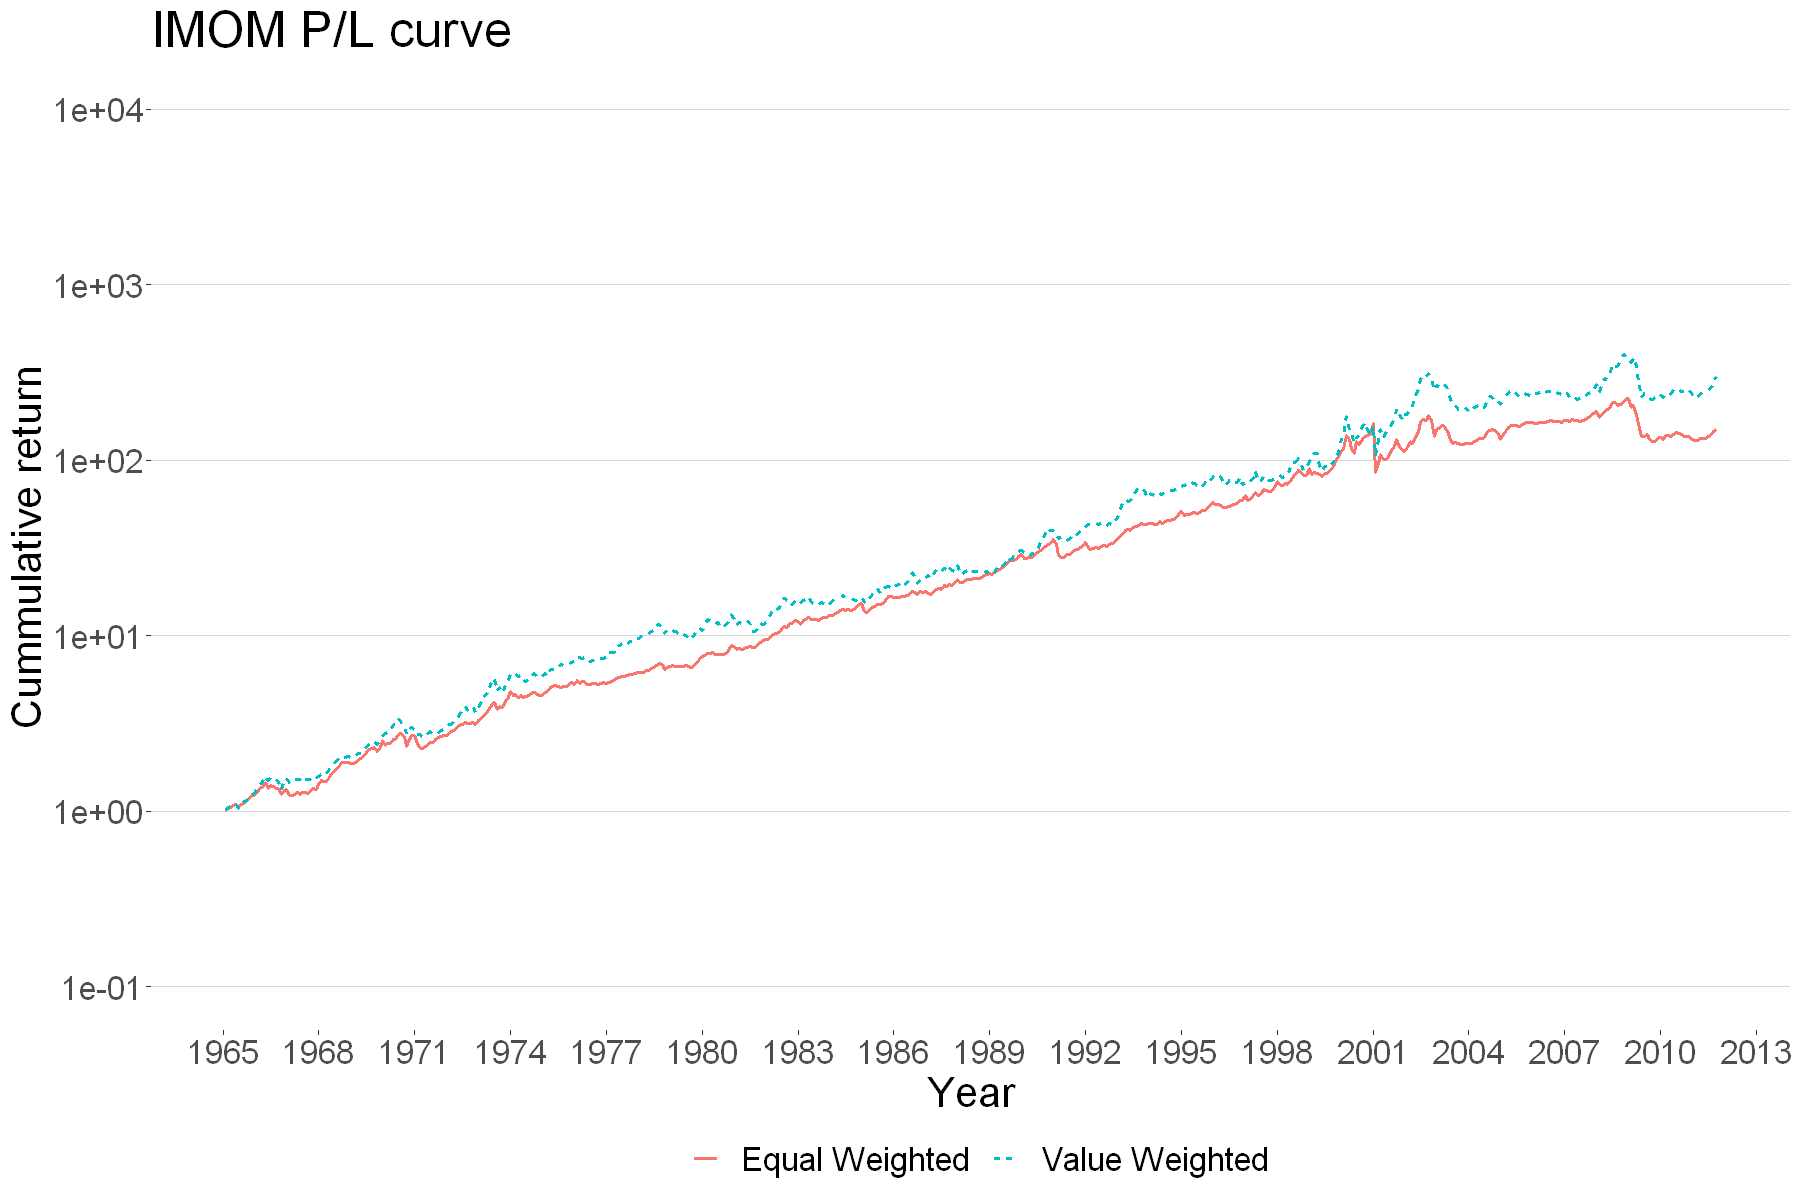

In [27]:
ggplot(data = figure_data_1, aes(x = as.Date(end_of_month), y = value, color = variable, linetype = variable)) +
    geom_line(size = 1) +
    labs(
        x = "Year",
        y = "Cummulative return",
        colour = "",
        linetype = ""
    ) +
    scale_y_log10(limit = c(1e-1, 1e04), n.breaks = 6) + ggtitle("IMOM P/L curve") +
    scale_x_date(breaks = "3 years", labels = scales::date_format("%Y")) +
    ggthemes::theme_hc(25)


## 3.4 Cumulative performance

In [28]:
#IMOM
strategy_wml[, cum_ew_long := cumprod(1 + ew_long + rf) - 1]
strategy_wml[, cum_vw_long := cumprod(1 + vw_long + rf) - 1]
strategy_wml[, cum_ew_short := cumprod(1 + ew_short + rf) - 1]
strategy_wml[, cum_vw_short := cumprod(1 + vw_short + rf) - 1]
strategy_wml[, cum_mkt := cumprod(1 + mkt_rf) - 1]

In [29]:
#MOM
strategy_MOM_wml = merge(
    mom_portfolios[mom_bin==5,], mom_portfolios[mom_bin==1,],
    suffixes=c('_long','_short'),
    by = c('end_of_month')
)
strategy_MOM_wml = merge(strategy_MOM_wml, ff_four, all.x = TRUE, by = c('end_of_month'))

strategy_MOM_wml[, ew := (ew_long - ew_short)]
strategy_MOM_wml[, vw := (vw_long - vw_short)]

strategy_MOM_wml[, cum_ew := cumprod(1 + ew + rf) - 1]
strategy_MOM_wml[, cum_vw := cumprod(1 + vw + rf) - 1]
strategy_MOM_wml[, cum_ew_long := cumprod(1 + ew_long + rf) - 1]
strategy_MOM_wml[, cum_vw_long := cumprod(1 + vw_long + rf) - 1]
strategy_MOM_wml[, cum_ew_short := cumprod(1 + ew_short + rf) - 1]
strategy_MOM_wml[, cum_vw_short := cumprod(1 + vw_short + rf) - 1]

In [30]:
figure_data_1.1 = merge(
    strategy_wml, strategy_MOM_wml,
    suffixes=c('_IMOM','_MOM'),
    by = c('end_of_month')
)
setDT(figure_data_1)

figure_data_1.1 = figure_data_1.1[,c(
    "end_of_month",
    "cum_vw_long_IMOM",
    "cum_vw_short_IMOM",
    "cum_vw_long_MOM",
    "cum_vw_short_MOM",
    "cum_mkt"
    )]

names(figure_data_1.1)[2:6] = c("IMOM (Long)", "IMOM (Short)", "MOM (Long)", "MOM (Short)", "Market")

figure_data_1.1 = melt(figure_data_1.1, id.vars = c("end_of_month"))
figure_data_1.1[, value := (value + 1)]

## Figure 3: Cumulative Performance <a class="anchor" id="figure_3"></a>
Cumulative performance of $1 invested in January 1965 in each of five portfolios: market, long and short legs of
value weighted MOM, and long and short legs of value weighted IMOM.

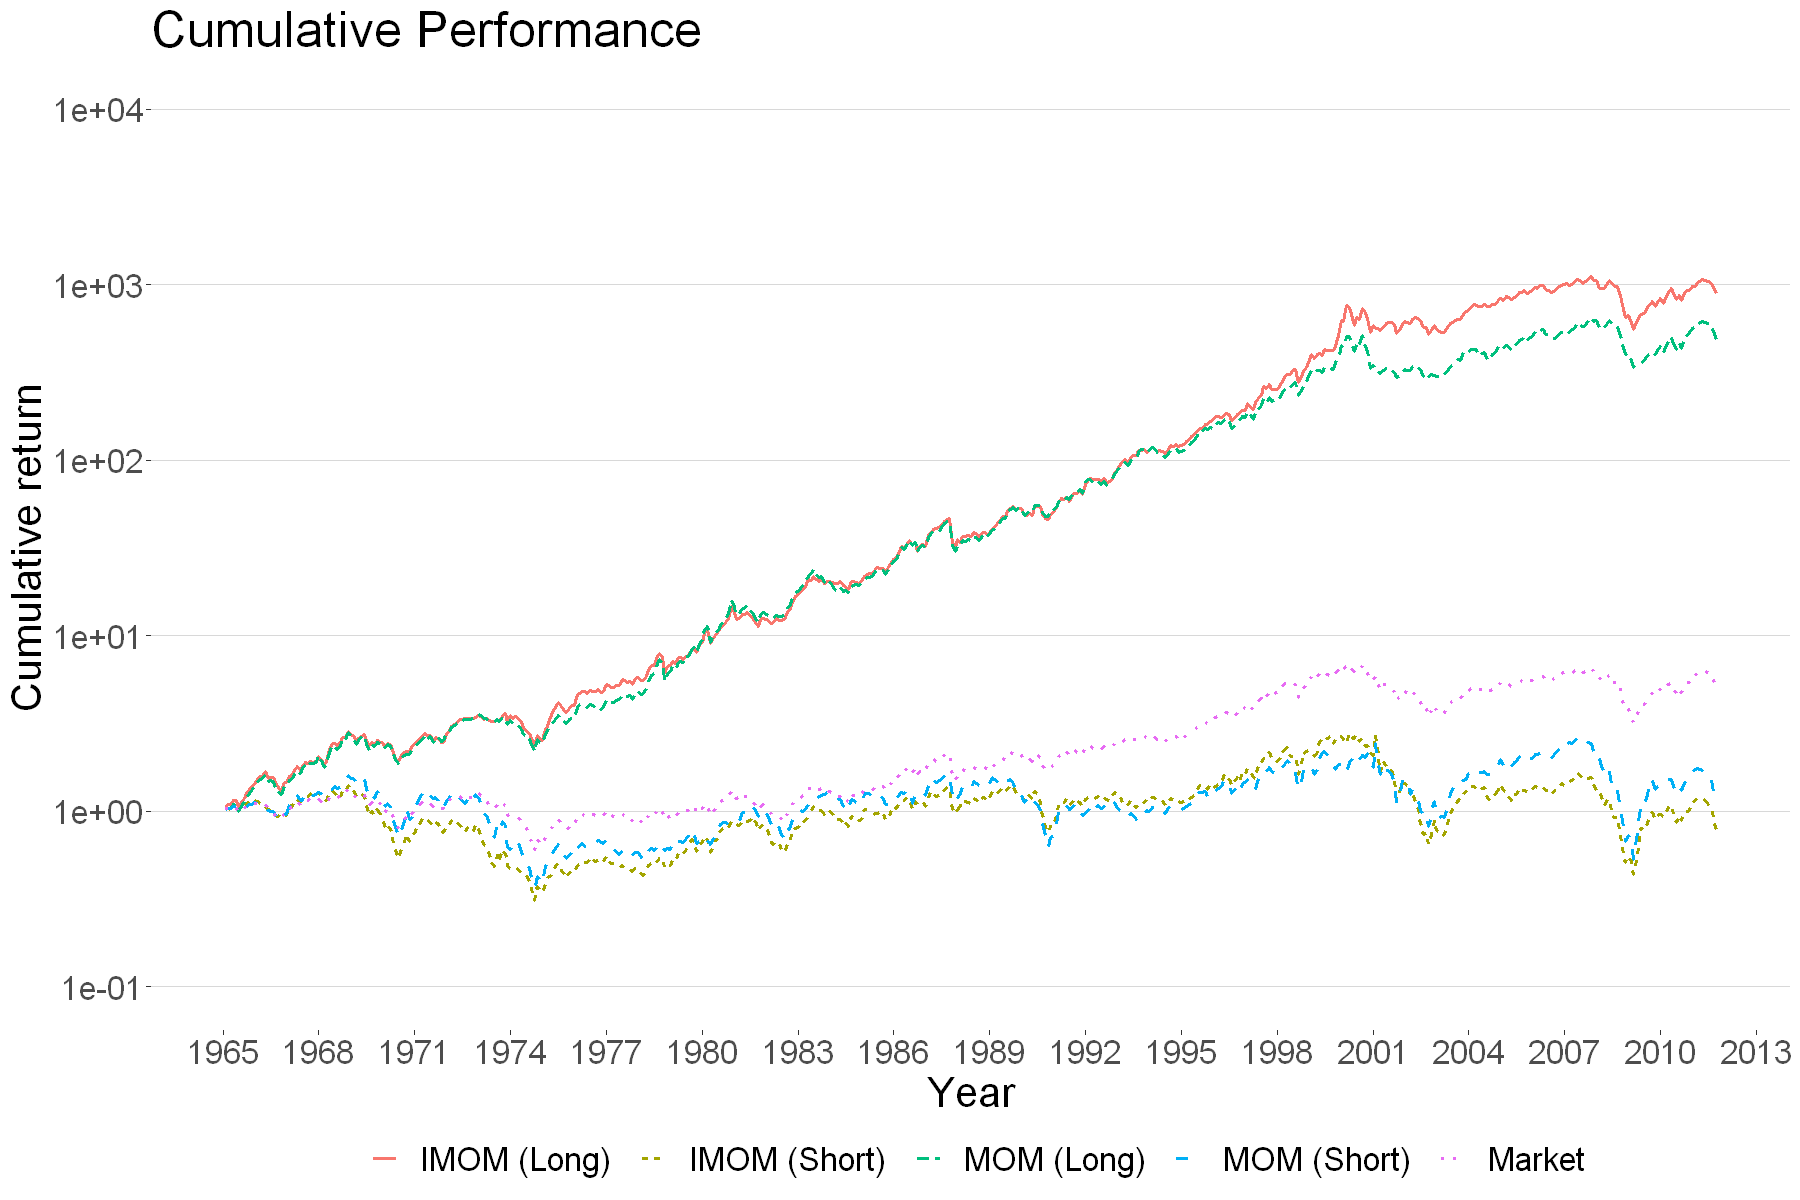

In [31]:
ggplot(data = figure_data_1.1, aes(x = as.Date(end_of_month), y = value, color = variable, linetype = variable)) +
    geom_line(size = 1) +
    labs(
        x = "Year",
        y = "Cumulative return",
        colour = "",
        linetype = ""
    ) +
    scale_y_log10(limit = c(1e-1, 1e04), n.breaks = 6) + ggtitle("Cumulative Performance") +
    scale_x_date(breaks = "3 years", labels = scales::date_format("%Y")) +
    ggthemes::theme_hc(25)

# 4. Size Analysis <a class="anchor" id="bullet_4"></a>

## 4.1 Apply Quantile Bins on Signal and Size

In [32]:
signal_3 = copy(signal_filtered)

In [33]:
apply_cap_split = function(mcap, hexcd, breaks){
    
    #Use NYSE stock for breakpoint
    include_in_quantiles = (hexcd == 1)
    
    # calculate quantiles (breakpoints)
    quantiles = quantile(
        ifelse(include_in_quantiles, mcap, NA),
        probs = breaks,
        na.rm = TRUE
    )
    
    quantiles['0%'] = min(mcap, na.rm = TRUE) - 1
    quantiles['100%'] = max(mcap, na.rm = TRUE) + 1
    
    # cut the data a bit more 
    return(cut(mcap, breaks = quantiles, labels = FALSE))
}


signal_3[, size_bin := apply_cap_split(mcap_lag1, hexcd, c(0, 0.2, 0.5, 1)), by = end_of_month]

signal_3[, idio_bin := apply_quantiles(idio_momentum, bins = 5), by = .(end_of_month, size_bin)]
signal_3[, mom_bin := apply_quantiles(momentum, bins = 5), by = .(end_of_month, size_bin)]


In [34]:
#Check size bin split
{
x = signal_3[, .(sum_mcap = sum(mcap_lag1), count = .N), by = .(end_of_month, size_bin)]
x = merge(x, x[, .(total_mcap = sum(sum_mcap), total_count = sum(count)), by = end_of_month], by = "end_of_month")
x[, mcap_perc := sum_mcap / total_mcap]
x[, count_perc := count / total_count]
x[, .(mean_mcap_perc = mean(mcap_perc), mean_count_perc = mean(count_perc)), keyby = size_bin]
}

size_bin,mean_mcap_perc,mean_count_perc
<int>,<dbl>,<dbl>
1,0.01980368,0.5027919
2,0.05391295,0.2258566
3,0.92628337,0.2713515


## 4.2 Create profolio

In [35]:
idio_portfolios_size = signal_3[, .(
    ew = mean(ret_rf),
    vw = sum(ret_rf * mcap_lag1) / sum(mcap_lag1)
), by = .(end_of_month, idio_bin, size_bin)]


mom_portfolios_size = signal_3[, .(
    ew = mean(ret_rf),
    vw = sum(ret_rf * mcap_lag1) / sum(mcap_lag1)
), by = .(end_of_month, mom_bin, size_bin)]

## 4.3 Mean Retruns

In [36]:
#Mean return
n_size = nrow(idio_portfolios_size[, .N, by = end_of_month])

mean_ret_size = idio_portfolios_size[, 
    .(ew_annual = annualize_ret(mean(ew)),
        vw_annual = annualize_ret(mean(vw)),
        t_ew = mean(ew)/sd(ew) * sqrt(n_size),
        t_vw = mean(vw)/sd(vw) * sqrt(n_size)
    ), 
    keyby = .(size_bin, idio_bin)]

mean_ret_size


size_bin,idio_bin,ew_annual,vw_annual,t_ew,t_vw
<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,8.277632,-2.414207,1.7187517,-0.5622360
1,2,9.698290,5.820880,2.6703502,1.6604360
1,3,12.975468,10.443306,3.9134008,3.3043106
1,4,16.635851,14.384490,5.0732790,4.5528483
1,5,20.979380,19.382113,5.2359183,4.8662826
2,1,1.189480,1.369758,0.3057563,0.3535121
2,2,7.876063,7.641410,2.5312476,2.4727001
2,3,10.147947,10.036399,3.6195891,3.6170671
2,4,12.806271,12.503842,4.3741576,4.3240695


In [37]:
#WML
strategy_wml_size = merge(
    idio_portfolios_size[idio_bin==5,], idio_portfolios_size[idio_bin==1,], 
    suffixes=c('_long','_short'), 
    by = c('end_of_month', 'size_bin')
)

strategy_wml_size[, ew := (ew_long - ew_short)]
strategy_wml_size[, vw := (vw_long - vw_short)]

strategy_wml_size_summary = strategy_wml_size[,
    .(
        ew_mean = annualize_ret(mean(ew)),
        vw_mean = annualize_ret(mean(vw)),
        ew_t = sharpe(ew) * sqrt(n),
        vw_t = sharpe(vw) * sqrt(n)
    ),
    keyby = .(size_bin)]

strategy_wml_size_summary


size_bin,ew_mean,vw_mean,ew_t,vw_t
<int>,<dbl>,<dbl>,<dbl>,<dbl>
1,11.812778,22.285799,4.796489,9.051155
2,14.042119,13.594099,6.065110,5.776360
3,9.828232,9.262009,4.395237,3.905541


## 4.4 Alpha

In [38]:
#Alpha
strategy_wml_size = merge(strategy_wml_size, ff_four, all.x = TRUE, by = c("end_of_month"))
strategy_wml_size = merge(strategy_wml_size, ff_five, all.x = TRUE, suffixes = c("", "_ff5"), by = c('end_of_month'))

In [39]:
ff_alpha = function(inp_data, vw_flag) {
    if (vw_flag) {
        wml = inp_data[,vw]
    }
    else {
        wml = inp_data[,ew]
    }
    
    lm_fit_capm = lm(wml ~ mkt_rf, data = inp_data)
    lm_fit_3f = lm(wml ~ mkt_rf + smb + hml, data = inp_data)
    lm_fit_4f = lm(wml ~ mkt_rf + smb + hml + mom, data = inp_data)
    lm_fit_5f = lm(wml ~ mkt_rf_ff5 + smb_ff5 + hml_ff5 + rmw + cma, data = inp_data)
    
    output = data.table(
        capm_alpha = annualize_ret(lm_fit_capm$coefficients[1]),
        capm_t = summary(lm_fit_capm)[["coefficients"]][1, "t value"],
        ff3_alpha = annualize_ret(lm_fit_3f$coefficients[1]),
        ff3_t = summary(lm_fit_3f)[["coefficients"]][1, "t value"],
        ff4_alpha = annualize_ret(lm_fit_4f$coefficients[1]),
        ff4_t = summary(lm_fit_4f)[["coefficients"]][1, "t value"],
        ff5_alpha = annualize_ret(lm_fit_5f$coefficients[1]),
        ff5_t = summary(lm_fit_5f)[["coefficients"]][1, "t value"]
    )
    
    return(output)
}

In [40]:
alpha_size = data.table(size_bin = 1, portfolio = "vw", ff_alpha(strategy_wml_size[size_bin == 1], vw_flag = TRUE))
alpha_size = rbind(alpha_size, data.table(size_bin = 2, portfolio = "vw", ff_alpha(strategy_wml_size[size_bin == 2], vw_flag = TRUE)))
alpha_size = rbind(alpha_size, data.table(size_bin = 3, portfolio = "vw", ff_alpha(strategy_wml_size[size_bin == 3], vw_flag = TRUE)))


for(i in 1:3){
    alpha_size = rbind(alpha_size, data.table(size_bin = i, portfolio = "ew", ff_alpha(strategy_wml_size[size_bin == i], vw_flag = FALSE)))
}

In [41]:
alpha_size

size_bin,portfolio,capm_alpha,capm_t,ff3_alpha,ff3_t,ff4_alpha,ff4_t,ff5_alpha,ff5_t
<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,vw,23.358421,9.578888,22.97076,9.273298,13.0664510,8.0078173,19.324063,7.849112
2,vw,14.470999,6.186601,15.20932,6.469366,5.6382475,3.8947827,14.312074,5.917852
3,vw,9.871636,4.161589,10.03812,4.236671,0.9282214,0.6036632,9.537323,3.917429
1,ew,12.794779,5.236810,12.42096,5.013385,3.8622599,2.1189645,8.759679,3.573163
2,ew,14.854674,6.446215,15.60976,6.738835,6.2357402,4.3115084,14.807745,6.202836
3,ew,10.530431,4.722661,10.61204,4.772290,1.5191786,1.1499689,9.761396,4.273489


## 4.5 IMOM Summary

In [42]:
x = data.table(portfolio = "vw", dcast(mean_ret_size, size_bin ~ idio_bin, value.var = "vw_annual"))
x = rbind(x,data.table(portfolio = "ew", dcast(mean_ret_size, size_bin ~ idio_bin, value.var = "ew_annual")))

y = data.table(portfolio = "vw", dcast(mean_ret_size, size_bin ~ idio_bin, value.var = "t_vw"))
y = rbind(y,data.table(portfolio = "ew", dcast(mean_ret_size, size_bin ~ idio_bin, value.var = "t_ew")))
names(y)[3:7] = paste0(names(y)[3:7], "_t")

z = data.table(portfolio = "vw", strategy_wml_size_summary[, .(size_bin, wml = vw_mean, wml_t = vw_t)])
z = rbind(z, data.table(portfolio = "ew", strategy_wml_size_summary[, .(size_bin, wml = ew_mean, wml_t = ew_t)]))


size_summary = merge(x, y, keyby = c("portfolio", "size_bin"))
size_summary = merge(size_summary, z, keyby = c("portfolio", "size_bin"))
size_summary = merge(size_summary, alpha_size, keyby = c("portfolio", "size_bin"))

rm(x)
rm(y)
rm(z)

In [43]:
size_names = c("Micro", "Small", "Large")
names(size_summary)[2] = "Size"
size_summary[, Size := size_names[Size]]

### Panel A: EW - IMOM

In [44]:
summary_data = size_summary[portfolio == "ew", -1]

size_summary_output_panel_A = data.table(t(lapply(summary_data[1, .SD, .SDcol = -grep("_t", names(summary_data))], round_num)))
for(i in 1:5){
    if(i %% 2 == 0){
        size_summary_output_panel_A = rbind(size_summary_output_panel_A, lapply(summary_data[i%/%2+1, .SD, .SDcol = -grep("_t", names(summary_data))],round_num), use.names = FALSE)
    } else {
        size_summary_output_panel_A = rbind(size_summary_output_panel_A, lapply(summary_data[i%/%2+1, .(NA, .SD), .SDcol = c(grep("_t", names(summary_data)))], add_bracket), use.names = FALSE)
    }
}

rm(summary_data)

### Panel B: VW - IMOM

In [45]:
summary_data = size_summary[portfolio == "vw", -1]

size_summary_output_panel_B = data.table(t(lapply(summary_data[1, .SD, .SDcol = -grep("_t", names(summary_data))], round_num)))
for(i in 1:5){
    if(i %% 2 == 0){
        size_summary_output_panel_B = rbind(size_summary_output_panel_B, lapply(summary_data[i%/%2+1, .SD, .SDcol = -grep("_t", names(summary_data))],round_num), use.names = FALSE)
    } else {
        size_summary_output_panel_B = rbind(size_summary_output_panel_B, lapply(summary_data[i%/%2+1, .(NA, .SD), .SDcol = c(grep("_t", names(summary_data)))], add_bracket), use.names = FALSE)
    }
}

rm(summary_data)

## 4.6 Do the same for MOM

In [46]:
#Mean return
n_size_MOM = nrow(mom_portfolios_size[, .N, by = end_of_month])

mean_ret_size_MOM = mom_portfolios_size[, 
    .(ew_annual = annualize_ret(mean(ew)),
        vw_annual = annualize_ret(mean(vw)),
        t_ew = mean(ew)/sd(ew) * sqrt(n_size_MOM),
        t_vw = mean(vw)/sd(vw) * sqrt(n_size_MOM)
    ), 
    keyby = .(size_bin, mom_bin)]

mean_ret_size_MOM

size_bin,mom_bin,ew_annual,vw_annual,t_ew,t_vw
<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,11.488285,-1.379002,2.1897276,-0.2912496
1,2,9.756092,5.475104,2.5925490,1.4938270
1,3,12.001065,10.003520,3.6941898,3.1147446
1,4,15.776618,12.884380,4.8497917,4.1060731
1,5,19.350324,18.059830,5.0958967,4.7174270
2,1,2.801114,3.026661,0.7001889,0.7580717
2,2,8.815842,8.594154,2.8328281,2.7786977
2,3,9.904706,9.530835,3.4928804,3.3872701
2,4,11.712045,11.703424,3.9285416,3.9806614


In [47]:
#WML
strategy_wml_size_MOM = merge(
    mom_portfolios_size[mom_bin==5,], mom_portfolios_size[mom_bin==1,], 
    suffixes=c('_long','_short'), 
    by = c('end_of_month', 'size_bin')
)

strategy_wml_size_MOM[, ew := (ew_long - ew_short)]
strategy_wml_size_MOM[, vw := (vw_long - vw_short)]

strategy_wml_size_summary_MOM = strategy_wml_size_MOM[,
    .(
      ew_mean = annualize_ret(mean(ew)),
      vw_mean = annualize_ret(mean(vw)),
      ew_t = sharpe(ew) * sqrt(n),
      vw_t = sharpe(vw) * sqrt(n)
    ),
    keyby = .(size_bin)]

strategy_wml_size_summary_MOM

size_bin,ew_mean,vw_mean,ew_t,vw_t
<int>,<dbl>,<dbl>,<dbl>,<dbl>
1,7.118138,19.685923,2.204498,5.827928
2,10.880855,10.310031,3.743641,3.485275
3,8.445400,6.778368,3.019649,2.339147


In [48]:
#Alpha
strategy_wml_size_MOM = merge(strategy_wml_size_MOM, ff_four, all.x = TRUE, by = c("end_of_month"))
strategy_wml_size_MOM = merge(strategy_wml_size_MOM, ff_five, all.x = TRUE, suffixes = c("", "_ff5"), by = c('end_of_month'))


alpha_size_MOM = data.table(size_bin = 1, portfolio = "vw", ff_alpha(strategy_wml_size_MOM[size_bin == 1], vw_flag = TRUE))
alpha_size_MOM = rbind(alpha_size_MOM, data.table(size_bin = 2, portfolio = "vw", ff_alpha(strategy_wml_size_MOM[size_bin == 2], vw_flag = TRUE)))
alpha_size_MOM = rbind(alpha_size_MOM, data.table(size_bin = 3, portfolio = "vw", ff_alpha(strategy_wml_size_MOM[size_bin == 3], vw_flag = TRUE)))

for(i in 1:3){
    alpha_size_MOM = rbind(alpha_size_MOM, data.table(size_bin = i, portfolio = "ew", ff_alpha(strategy_wml_size_MOM[size_bin == i], vw_flag = FALSE)))
}

In [49]:
alpha_size_MOM

size_bin,portfolio,capm_alpha,capm_t,ff3_alpha,ff3_t,ff4_alpha,ff4_t,ff5_alpha,ff5_t
<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,vw,21.171352,6.322032,23.718483,6.979527,9.1888963,4.7434652,18.783205,5.591317
2,vw,10.974428,3.701766,13.815762,4.699941,0.5640042,0.4222235,12.240868,4.072000
3,vw,7.032966,2.414915,9.416532,3.269422,-3.7547928,-3.3145337,8.159455,2.759698
1,ew,8.305441,2.584933,10.221452,3.139556,-1.6745224,-0.7660778,5.566702,1.732021
2,ew,11.493351,3.944027,14.402972,4.988524,1.4270916,1.0607467,13.074741,4.416750
3,ew,8.746595,3.112446,11.175333,4.061177,-1.5638663,-1.4566242,10.083274,3.566306


## 4.7 IMOM Summary

In [50]:
x = data.table(portfolio = "vw", dcast(mean_ret_size_MOM, size_bin ~ mom_bin, value.var = "vw_annual"))
x = rbind(x,data.table(portfolio = "ew", dcast(mean_ret_size_MOM, size_bin ~ mom_bin, value.var = "ew_annual")))

y = data.table(portfolio = "vw", dcast(mean_ret_size_MOM, size_bin ~ mom_bin, value.var = "t_vw"))
y = rbind(y,data.table(portfolio = "ew", dcast(mean_ret_size_MOM, size_bin ~ mom_bin, value.var = "t_ew")))
names(y)[3:7] = paste0(names(y)[3:7], "_t")

z = data.table(portfolio = "vw", strategy_wml_size_summary_MOM[, .(size_bin, wml = vw_mean, wml_t = vw_t)])
z = rbind(z, data.table(portfolio = "ew", strategy_wml_size_summary_MOM[, .(size_bin, wml = ew_mean, wml_t = ew_t)]))


size_summary_MOM = merge(x, y, keyby = c("portfolio", "size_bin"))
size_summary_MOM = merge(size_summary_MOM, z, keyby = c("portfolio", "size_bin"))
size_summary_MOM = merge(size_summary_MOM, alpha_size_MOM, keyby = c("portfolio", "size_bin"))

rm(x)
rm(y)
rm(z)

In [51]:
size_names = c("Micro", "Small", "Large")
names(size_summary_MOM)[2] = "Size"
size_summary_MOM[, Size := size_names[Size]]

### Panel C: EW - MOM

In [52]:
summary_data = size_summary_MOM[portfolio == "ew", -1]

size_summary_output_panel_C = data.table(t(lapply(summary_data[1, .SD, .SDcol = -grep("_t", names(summary_data))], round_num)))
for(i in 1:5){
    if(i %% 2 == 0){
        size_summary_output_panel_C = rbind(size_summary_output_panel_C, lapply(summary_data[i%/%2+1, .SD, .SDcol = -grep("_t", names(summary_data))],round_num), use.names = FALSE)
    } else {
        size_summary_output_panel_C = rbind(size_summary_output_panel_C, lapply(summary_data[i%/%2+1, .(NA, .SD), .SDcol = c(grep("_t", names(summary_data)))], add_bracket), use.names = FALSE)
    }
}

rm(summary_data)

### Panel D: VW - MOM

In [53]:
summary_data = size_summary_MOM[portfolio == "vw", -1]

size_summary_output_panel_D = data.table(t(lapply(summary_data[1, .SD, .SDcol = -grep("_t", names(summary_data))], round_num)))
for(i in 1:5){
    if(i %% 2 == 0){
        size_summary_output_panel_D = rbind(size_summary_output_panel_D, lapply(summary_data[i%/%2+1, .SD, .SDcol = -grep("_t", names(summary_data))],round_num), use.names = FALSE)
    } else {
        size_summary_output_panel_D = rbind(size_summary_output_panel_D, lapply(summary_data[i%/%2+1, .(NA, .SD), .SDcol = c(grep("_t", names(summary_data)))], add_bracket), use.names = FALSE)
    }
}

rm(summary_data)

## Table 3: WML Portfolios in Size Groups <a class="anchor" id="table_3"></a>

In [54]:
IRdisplay::display_html(
        paste(capture.output(
            stargazer(size_summary_output_panel_A, size_summary_output_panel_B, type = "html", summary = FALSE, rownames = FALSE,
                     title = c("Panel A: EW - IMOM", "Panel B: VW - IMOM"))
        ),
        collapse='', sep='')
)
IRdisplay::display_html(
        paste(capture.output(
            stargazer(size_summary_output_panel_C, size_summary_output_panel_D, type = "html", summary = FALSE, rownames = FALSE,
                     title = c("Panel C: EW - MOM", "Panel D: VW - MOM"))
        ),
        collapse='', sep='')
)

Panel A: EW - IMOM Size 1 2 3 4 5 wml capm_alpha ff3_alpha ff4_alpha ff5_alpha Micro 8.28 9.7 12.98 16.64 20.98 11.81 12.79 12.42 3.86 8.76 (1.72) (2.67) (3.91) (5.07) (5.24) (4.8) (5.24) (5.01) (2.12) (3.57) Small 1.19 7.88 10.15 12.81 15.38 14.04 14.85 15.61 6.24 14.81 (0.31) (2.53) (3.62) (4.37) (4.08) (6.07) (6.45) (6.74) (4.31) (6.2) Large 1.72 5.97 7.49 8.45 11.71 9.83 10.53 10.61 1.52 9.76 (0.53) (2.32) (3.17) (3.5) (3.86) (4.4) (4.72) (4.77) (1.15) (4.27) Panel B: VW - IMOM Size 1 2 3 4 5 wml capm_alpha ff3_alpha ff4_alpha ff5_alpha Micro -2.41 5.82 10.44 14.38 19.38 22.29 23.36 22.97 13.07 19.32 (-0.56) (1.66) (3.3) (4.55) (4.87) (9.05) (9.58) (9.27) (8.01) (7.85) Small 1.37 7.64 10.04 12.5 15.13 13.59 14.47 15.21 5.64 14.31 (0.35) (2.47) (3.62) (4.32) (4.07) (5.78) (6.19) (6.47) (3.89) (5.92) Large 1.13 3.21 4.31 6.48 10.49 9.26 9.87 10.04 0.93 9.54 (0.38) (1.38) (2) (2.87) (3.69) (3.91) (4.16) (4.24) (0.6) (3.92)

Panel C: EW - MOM Size 1 2 3 4 5 wml capm_alpha ff3_alpha ff4_alpha ff5_alpha Micro 11.49 9.76 12 15.78 19.35 7.12 8.31 10.22 -1.67 5.57 (2.19) (2.59) (3.69) (4.85) (5.1) (2.2) (2.58) (3.14) (-0.77) (1.73) Small 2.8 8.82 9.9 11.71 13.96 10.88 11.49 14.4 1.43 13.07 (0.7) (2.83) (3.49) (3.93) (3.64) (3.74) (3.94) (4.99) (1.06) (4.42) Large 3.35 5.73 6.49 7.64 12.05 8.45 8.75 11.18 -1.56 10.08 (1.03) (2.22) (2.72) (3.12) (3.75) (3.02) (3.11) (4.06) (-1.46) (3.57) Panel D: VW - MOM Size 1 2 3 4 5 wml capm_alpha ff3_alpha ff4_alpha ff5_alpha Micro -1.38 5.48 10 12.88 18.06 19.69 21.17 23.72 9.19 18.78 (-0.29) (1.49) (3.11) (4.11) (4.72) (5.83) (6.32) (6.98) (4.74) (5.59) Small 3.03 8.59 9.53 11.7 13.62 10.31 10.97 13.82 0.56 12.24 (0.76) (2.78) (3.39) (3.98) (3.6) (3.49) (3.7) (4.7) (0.42) (4.07) Large 2.79 3.62 3.41 6 9.74 6.78 7.03 9.42 -3.75 8.16 (0.91) (1.53) (1.54) (2.57) (3.28) (2.34) (2.41) (3.27) (-3.31) (2.76)

In [55]:
stargazer(size_summary_output_panel_A, size_summary_output_panel_B, type = "latex", summary = FALSE, rownames = FALSE,
                     title = c("Panel A: EW - IMOM", "Panel B: VW - IMOM"))


% Table created by stargazer v.5.2.2 by Marek Hlavac, Harvard University. E-mail: hlavac at fas.harvard.edu
% Date and time: Wed, May 06, 2020 - 12:06:49 AM
\begin{table}[!htbp] \centering 
  \caption{Panel A: EW - IMOM} 
  \label{} 
\begin{tabular}{@{\extracolsep{5pt}} ccccccccccc} 
\\[-1.8ex]\hline 
\hline \\[-1.8ex] 
Size & 1 & 2 & 3 & 4 & 5 & wml & capm\_alpha & ff3\_alpha & ff4\_alpha & ff5\_alpha \\ 
\hline \\[-1.8ex] 
Micro & 8.28 & 9.7 & 12.98 & 16.64 & 20.98 & 11.81 & 12.79 & 12.42 & 3.86 & 8.76 \\ 
 & (1.72) & (2.67) & (3.91) & (5.07) & (5.24) & (4.8) & (5.24) & (5.01) & (2.12) & (3.57) \\ 
Small & 1.19 & 7.88 & 10.15 & 12.81 & 15.38 & 14.04 & 14.85 & 15.61 & 6.24 & 14.81 \\ 
 & (0.31) & (2.53) & (3.62) & (4.37) & (4.08) & (6.07) & (6.45) & (6.74) & (4.31) & (6.2) \\ 
Large & 1.72 & 5.97 & 7.49 & 8.45 & 11.71 & 9.83 & 10.53 & 10.61 & 1.52 & 9.76 \\ 
 & (0.53) & (2.32) & (3.17) & (3.5) & (3.86) & (4.4) & (4.72) & (4.77) & (1.15) & (4.27) \\ 
\hline \\[-1.8ex] 
\end{tabular} 


In [56]:
stargazer(size_summary_output_panel_C, size_summary_output_panel_D, type = "latex", summary = FALSE, rownames = FALSE,
                     title = c("Panel C: EW - MOM", "Panel D: VW - MOM"))


% Table created by stargazer v.5.2.2 by Marek Hlavac, Harvard University. E-mail: hlavac at fas.harvard.edu
% Date and time: Wed, May 06, 2020 - 12:06:49 AM
\begin{table}[!htbp] \centering 
  \caption{Panel C: EW - MOM} 
  \label{} 
\begin{tabular}{@{\extracolsep{5pt}} ccccccccccc} 
\\[-1.8ex]\hline 
\hline \\[-1.8ex] 
Size & 1 & 2 & 3 & 4 & 5 & wml & capm\_alpha & ff3\_alpha & ff4\_alpha & ff5\_alpha \\ 
\hline \\[-1.8ex] 
Micro & 11.49 & 9.76 & 12 & 15.78 & 19.35 & 7.12 & 8.31 & 10.22 & -1.67 & 5.57 \\ 
 & (2.19) & (2.59) & (3.69) & (4.85) & (5.1) & (2.2) & (2.58) & (3.14) & (-0.77) & (1.73) \\ 
Small & 2.8 & 8.82 & 9.9 & 11.71 & 13.96 & 10.88 & 11.49 & 14.4 & 1.43 & 13.07 \\ 
 & (0.7) & (2.83) & (3.49) & (3.93) & (3.64) & (3.74) & (3.94) & (4.99) & (1.06) & (4.42) \\ 
Large & 3.35 & 5.73 & 6.49 & 7.64 & 12.05 & 8.45 & 8.75 & 11.18 & -1.56 & 10.08 \\ 
 & (1.03) & (2.22) & (2.72) & (3.12) & (3.75) & (3.02) & (3.11) & (4.06) & (-1.46) & (3.57) \\ 
\hline \\[-1.8ex] 
\end{tabular} 
\en

# 5. IUMD Factor <a class="anchor" id="bullet_5"></a>

## 5.1 Build IUMD Factor

In [57]:
signal_4 = copy(signal_filtered)

In [58]:
signal_4[, size_bin := apply_cap_split(mcap_lag1, hexcd, c(0, 0.5, 1)), by = end_of_month]
signal_4[, idio_bin := apply_quantiles(idio_momentum, bins = 10), by = .(end_of_month, size_bin)]
signal_4[, IUMD_bin := ifelse(idio_bin <= 3, 1, ifelse(idio_bin >= 8, 3, 2))]

idio_portfolios_IUMD = signal_4[, .(
    ew = mean(ret_rf),
    vw = sum(ret_rf * mcap_lag1) / sum(mcap_lag1)
), by = .(end_of_month, IUMD_bin, size_bin)]

strategy_wml_IUMD = merge(
    idio_portfolios_IUMD[IUMD_bin==3,], idio_portfolios_IUMD[IUMD_bin==1,], 
    suffixes=c('_long','_short'), 
    by = c('end_of_month', 'size_bin')
)

strategy_wml_IUMD[, ew := (ew_long - ew_short)]
strategy_wml_IUMD[, vw := (vw_long - vw_short)]

IUMD = strategy_wml_IUMD[, .(IUMD = mean(vw)), keyby = c("end_of_month")]

## 5.2 Factor Loadings

### Panel A: MOM Portfolios

In [59]:
factor_loading_lm = function(inp_data){
    fit = lm(vw ~ mom + IUMD, data = inp_data)
    output = data.table(t(fit$coefficients))
    return(output)
}

In [60]:
#MOM
MOM_strategy_wml = merge(
    mom_portfolios[mom_bin==5,], mom_portfolios[mom_bin==1,], 
    suffixes=c('_long','_short'), 
    by = c('end_of_month')
)

MOM_strategy_wml[, ew := (ew_long - ew_short)]
MOM_strategy_wml[, vw := (vw_long - vw_short)]


MOM_mean_ret = mom_portfolios[, .("Excess Return" = annualize_ret(mean(vw))), keyby = mom_bin]
MOM_strategy_wml_summary = MOM_strategy_wml[, .("Excess Return" = annualize_ret(mean(vw)))]

MOM_excess_ret = rbind(MOM_mean_ret, data.table(mom_bin = "WML", MOM_strategy_wml_summary))

In [61]:
#Alpha
MOM_regress = merge(mom_portfolios, ff_four, all.x = TRUE, by = c('end_of_month'))
MOM_regress = merge(MOM_regress, IUMD, all.x = TRUE, by = c('end_of_month'))

MOM_regress_wml = merge(MOM_strategy_wml, ff_four, all.x = TRUE, by = c('end_of_month'))
MOM_regress_wml = merge(MOM_regress_wml, IUMD, all.x = TRUE, by = c('end_of_month'))


MOM_fit = MOM_regress[, factor_loading_lm(data.table(vw, mom, IUMD)), keyby = mom_bin]
MOM_fit_wml = MOM_regress_wml[, factor_loading_lm(data.table(vw, mom, IUMD))]

In [62]:
#Summary

MOM_factor_load_summary = rbind(MOM_fit[, c(1,3:4)], data.table(mom_bin = "WML", MOM_fit_wml[,2:3]))
MOM_factor_load_summary = merge(MOM_excess_ret, MOM_factor_load_summary, by = c("mom_bin"))
MOM_factor_load_summary = dcast(melt(MOM_factor_load_summary, id.vars = "mom_bin"), variable ~ mom_bin)


names(MOM_factor_load_summary)[c(2, 6, 7)] = c("Losers", "Winners", "WML")

MOM_factor_load_summary[, spread := Winners - Losers]
MOM_factor_load_summary[2:3, slope := MOM_factor_load_summary[1, spread] / spread]

MOM_factor_load_summary[, variable := c("Excess Return", "UMD Coefficient", "IUMD Coefficient")]

### Panel B: IMOM Portfolios

In [63]:
#IMOM
IMOM_regress = merge(idio_portfolios, ff_four, all.x = TRUE, by = c('end_of_month'))
IMOM_regress = merge(IMOM_regress, IUMD, all.x = TRUE, by = c('end_of_month'))

IMOM_regress_wml = merge(strategy_wml, IUMD, all.x = TRUE, by = c('end_of_month'))


IMOM_fit = IMOM_regress[, factor_loading_lm(data.table(vw, mom, IUMD)), keyby = idio_bin]
IMOM_fit_wml = IMOM_regress_wml[, factor_loading_lm(data.table(vw, mom, IUMD))]

In [64]:
#Summary

x = rbind(IMOM_fit[, c(1,3:4)], data.table(idio_bin = "WML", IMOM_fit_wml[,2:3]))
x = dcast(melt(x, id.vars = "idio_bin"), variable ~ idio_bin)

IMOM_factor_load_summary = data.table(variable = "Excess Return", 
    wml_summary[portfolio == "vw", .SD, .SDcol = -c(1, grep("_t", names(wml_summary)))]
)
IMOM_factor_load_summary = rbind(IMOM_factor_load_summary, x, use.names = FALSE)

rm(x)


names(IMOM_factor_load_summary)[c(2, 6, 7)] = c("Losers", "Winners", "WML")

IMOM_factor_load_summary[, spread := Winners - Losers]
IMOM_factor_load_summary[2:3, slope := IMOM_factor_load_summary[1, spread] / spread]

IMOM_factor_load_summary[, variable := c("Excess Return", "UMD Coefficient", "IUMD Coefficient")]

## Table 5: Excess Returns and Factor Loadings <a class="anchor" id="table_5"></a>

In [65]:
IRdisplay::display_html(
        paste(capture.output(
            stargazer(MOM_factor_load_summary[,-8], IMOM_factor_load_summary[,-8], type = "html", summary = FALSE, rownames = FALSE,
                     title = c("Panel A: MOM Portfolios", "Panel B: IMOM Portfolios"))
        ),
        collapse='', sep='')
)

Panel A: MOM Portfolios variable Losers 2 3 4 Winners WML slope Excess Return -1.588 3.128 3.816 6.558 10.445 12.210 UMD Coefficient -0.705 -0.436 -0.047 0.268 0.440 1.145 10.514 IUMD Coefficient -0.514 -0.362 -0.412 -0.436 -0.211 0.304 39.618 Panel B: IMOM Portfolios variable Losers 2 3 4 Winners WML slope Excess Return -2.706 3.735 4.897 6.819 11.798 14.871 UMD Coefficient -0.087 0.012 -0.009 -0.084 -0.012 0.075 193.786 IUMD Coefficient -1.028 -0.718 -0.341 0.034 0.326 1.353 10.717

In [66]:
stargazer(MOM_factor_load_summary[,-8], IMOM_factor_load_summary[,-8], type = "latex", summary = FALSE, rownames = FALSE,
                     title = c("Panel A: MOM Portfolios", "Panel B: IMOM Portfolios"))



% Table created by stargazer v.5.2.2 by Marek Hlavac, Harvard University. E-mail: hlavac at fas.harvard.edu
% Date and time: Wed, May 06, 2020 - 12:06:54 AM
\begin{table}[!htbp] \centering 
  \caption{Panel A: MOM Portfolios} 
  \label{} 
\begin{tabular}{@{\extracolsep{5pt}} cccccccc} 
\\[-1.8ex]\hline 
\hline \\[-1.8ex] 
variable & Losers & 2 & 3 & 4 & Winners & WML & slope \\ 
\hline \\[-1.8ex] 
Excess Return & $$-$1.588$ & $3.128$ & $3.816$ & $6.558$ & $10.445$ & $12.210$ & $$ \\ 
UMD Coefficient & $$-$0.705$ & $$-$0.436$ & $$-$0.047$ & $0.268$ & $0.440$ & $1.145$ & $10.514$ \\ 
IUMD Coefficient & $$-$0.514$ & $$-$0.362$ & $$-$0.412$ & $$-$0.436$ & $$-$0.211$ & $0.304$ & $39.618$ \\ 
\hline \\[-1.8ex] 
\end{tabular} 
\end{table} 

% Table created by stargazer v.5.2.2 by Marek Hlavac, Harvard University. E-mail: hlavac at fas.harvard.edu
% Date and time: Wed, May 06, 2020 - 12:06:54 AM
\begin{table}[!htbp] \centering 
  \caption{Panel B: IMOM Portfolios} 
  \label{} 
\begin{tabular}

## 5.3 Spanning Tests

In [67]:
#IUMU
span_regress = merge(IUMD, ff_four, all.x = TRUE,  by = c("end_of_month"))
span_regress = merge(span_regress, ff_five, all.x = TRUE, suffixes = c("", "_ff5") , by = c("end_of_month"))


fit_IUMD_0 = lm(IUMD ~ 1, data = span_regress)
fit_IUMD_1 = lm(IUMD ~ mom, data = span_regress)
fit_IUMD_ff4 = lm(IUMD ~ mom + mkt_rf + smb + hml, data = span_regress)
fit_IUMD_ff5 = lm(IUMD ~ mom + mkt_rf_ff5 + smb_ff5 + hml_ff5 + rmw + cma, data = span_regress)

In [68]:
#UMD
fit_UMD_0 = lm(mom ~ 1, data = span_regress)
fit_UMD_1 = lm(mom ~ IUMD, data = span_regress)
fit_UMD_ff4 = lm(mom ~ IUMD + mkt_rf + smb + hml, data = span_regress)
fit_UMD_ff5 = lm(mom ~ IUMD + mkt_rf_ff5 + smb_ff5 + hml_ff5 + rmw + cma, data = span_regress)

In [69]:
summerize_IUMD_factors = function(data, port){
    output = data.frame()
    output[1,1] = port
    
    summary_data = summary(data)
    num_of_factor = nrow(summary_data[["coefficients"]])
    is_ff5 = ifelse(num_of_factor == 6, TRUE, FALSE)
    
    is_UMD = ifelse(port == "IUMD", TRUE, FALSE)
    
    #value
    output[1, 2] = annualize_ret(summary_data[["coefficients"]][1, "Estimate"])
    
    ff5_skip = 0
    iumd_skip = 0
    for (i in 2:8) {
        if (i == 2 && is_UMD){
            output[1, 1+i] = NA
            iumd_skip = 1;
        }
        else if (i == 3 && !is_UMD){
            output[1, 1+i] = NA
            iumd_skip = 1;
        }
        else if (i == 6 && is_ff5){
            output[1, 1+i] = NA
            ff5_skip = 1;
        }
        else if (i <= num_of_factor + ff5_skip + iumd_skip){
            output[1, 1+i] = summary_data[["coefficients"]][i-ff5_skip-iumd_skip, "Estimate"]
        }
        else {
            output[1, 1+i] = NA
        }
    }
    
    #T-stat
    ff5_skip = 0
    iumd_skip = 0
    for (i in 1:8) {
        if (i == 2 && is_UMD){
            output[1, 9+i] = NA
            iumd_skip = 1;
        }
        else if (i == 3 && !is_UMD){
            output[1, 9+i] = NA
            iumd_skip = 1;
        }
        else if (i == 6 && is_ff5){
            output[1, 9+i] = NA
            ff5_skip = 1;
        }
        else if (i <= num_of_factor + ff5_skip + iumd_skip){
            output[1, 9+i] = summary_data[["coefficients"]][i-ff5_skip-iumd_skip, "t value"]
        }
        else {
            output[1, 9+i] = NA
        }
    }
    
    if (num_of_factor == 1){
        output[1, 18] = NA
    }
    else {
        output[1, 18] = summary_data[["r.squared"]]
    }
    
    return(output)
}

IUMD_factor_summary = data.table(
    "Dependent Variable" = character(), 
    Alpha = numeric(), IUMD = numeric(), UMD = numeric(), MKT = numeric(), 
    SMB = numeric(), HML = numeric(), RMW = numeric(), CMA = numeric(), 
    alpha_t = numeric(), iumd_t = numeric(), umd_t = numeric(), mkt_t = numeric(), 
    smb_t = numeric(), hml_t = numeric(), rmw_t = numeric(), cma_t = numeric(), 
    R_squared = numeric()
)

IUMD_factor_summary = rbind(IUMD_factor_summary, summerize_IUMD_factors(fit_IUMD_0, "IUMD"), use.names = FALSE)
IUMD_factor_summary = rbind(IUMD_factor_summary, summerize_IUMD_factors(fit_IUMD_1, "IUMD"), use.names = FALSE)
IUMD_factor_summary = rbind(IUMD_factor_summary, summerize_IUMD_factors(fit_IUMD_ff4, "IUMD"), use.names = FALSE)
IUMD_factor_summary = rbind(IUMD_factor_summary, summerize_IUMD_factors(fit_IUMD_ff5, "IUMD"), use.names = FALSE)
IUMD_factor_summary = rbind(IUMD_factor_summary, summerize_IUMD_factors(fit_UMD_0, "UMD"), use.names = FALSE)
IUMD_factor_summary = rbind(IUMD_factor_summary, summerize_IUMD_factors(fit_UMD_1, "UMD"), use.names = FALSE)
IUMD_factor_summary = rbind(IUMD_factor_summary, summerize_IUMD_factors(fit_UMD_ff4, "UMD"), use.names = FALSE)
IUMD_factor_summary = rbind(IUMD_factor_summary, summerize_IUMD_factors(fit_UMD_ff5, "UMD"), use.names = FALSE)


In [70]:
summary_data = IUMD_factor_summary

IUMD_factor_summary_output = data.table(t(lapply(summary_data[1, .SD, .SDcol = -grep("_t", names(summary_data))], round_num)))
for(i in 1:15){
    if(i %% 2 == 0){
        IUMD_factor_summary_output = rbind(IUMD_factor_summary_output, lapply(summary_data[i%/%2+1, .SD, .SDcol = -grep("_t", names(summary_data))],round_num), use.names = FALSE)
    } else {
        IUMD_factor_summary_output = rbind(IUMD_factor_summary_output, lapply(summary_data[i%/%2+1, .(NA, .SD, NA), .SDcol = c(grep("_t", names(summary_data)))], add_bracket), use.names = FALSE)
    }
}

rm(summary_data)


## Table 6: Spanning Tests <a class="anchor" id="table_6"></a>

In [71]:
IRdisplay::display_html(
        paste(capture.output(
            stargazer(IUMD_factor_summary_output, type = "html", summary = FALSE, rownames = FALSE)
        ),
        collapse='', sep='')
)

Dependent Variable Alpha IUMD UMD MKT SMB HML RMW CMA R_squared IUMD 10.25 (5.76) IUMD 4.03 0.66 0.72 (4.33) (38.03) IUMD 3.23 0.66 -0.04 0.1 0.14 0.74 (3.52) (38.58) (-2.13) (4.29) (5.17) IUMD 3.77 0.67 -0.04 0.06 0.11 -0.13 0.04 0.75 (4.04) (38.58) (-2.16) (2.39) (3.01) (-3.67) (0.68) UMD 9.24 (4.04) UMD -1.84 1.09 0.72 (-1.55) (38.03) UMD -0.47 1.1 -0.02 -0.1 -0.23 0.74 (-0.4) (38.58) (-0.74) (-3.15) (-6.69) UMD -1.69 1.09 0.01 -0.03 -0.25 0.22 0.08 0.75 (-1.44) (38.58) (0.21) (-1.09) (-5.51) (5.06) (1.2)

In [72]:
stargazer(IUMD_factor_summary_output, type = "latex", summary = FALSE, rownames = FALSE)


% Table created by stargazer v.5.2.2 by Marek Hlavac, Harvard University. E-mail: hlavac at fas.harvard.edu
% Date and time: Wed, May 06, 2020 - 12:06:56 AM
\begin{table}[!htbp] \centering 
  \caption{} 
  \label{} 
\begin{tabular}{@{\extracolsep{5pt}} cccccccccc} 
\\[-1.8ex]\hline 
\hline \\[-1.8ex] 
Dependent Variable & Alpha & IUMD & UMD & MKT & SMB & HML & RMW & CMA & R\_squared \\ 
\hline \\[-1.8ex] 
IUMD & 10.25 &  &  &  &  &  &  &  &  \\ 
 & (5.76) &  &  &  &  &  &  &  &  \\ 
IUMD & 4.03 &  & 0.66 &  &  &  &  &  & 0.72 \\ 
 & (4.33) &  & (38.03) &  &  &  &  &  &  \\ 
IUMD & 3.23 &  & 0.66 & -0.04 & 0.1 & 0.14 &  &  & 0.74 \\ 
 & (3.52) &  & (38.58) & (-2.13) & (4.29) & (5.17) &  &  &  \\ 
IUMD & 3.77 &  & 0.67 & -0.04 & 0.06 & 0.11 & -0.13 & 0.04 & 0.75 \\ 
 & (4.04) &  & (38.58) & (-2.16) & (2.39) & (3.01) & (-3.67) & (0.68) &  \\ 
UMD & 9.24 &  &  &  &  &  &  &  &  \\ 
 & (4.04) &  &  &  &  &  &  &  &  \\ 
UMD & -1.84 & 1.09 &  &  &  &  &  &  & 0.72 \\ 
 & (-1.55) & (38.03) &

## 5.4 UMD Extreme Months

In [73]:
ff_four_in_sample = ff_four[end_of_month >= SAMPLE_START_DATE & end_of_month <= SAMPLE_END_DATE]

ff_four_in_sample[, mkt := mkt_rf + rf]
ff_four_in_sample[, prev_year_mkt := (roll_prod(1 + coalesce(mkt, 0), n = 12, fill = NA, align = 'right')) - 1]

umd_extreme = ff_four_in_sample[order(mom)] %>% head(10)
umd_extreme = merge(umd_extreme, IUMD, by = "end_of_month")

umd_extreme_summary = umd_extreme[, .(
    year = year(end_of_month), 
    month = month(end_of_month),
    MKT_Previous_Year = prev_year_mkt * 100, MKT = mkt * 100, 
    UMD = mom * 100, IUMD = IUMD * 100
)]
setkey(umd_extreme_summary, UMD)

## Table 7: UMD Extreme Months <a class="anchor" id="table_7"></a>

In [74]:
IRdisplay::display_html(
        paste(capture.output(
            stargazer(umd_extreme_summary, type = "html", summary = FALSE, rownames = FALSE)
        ),
        collapse='', sep='')
)

year month MKT_Previous_Year MKT UMD IUMD 2,009 4 -33.687 10.210 -26.971 -13.191 2,001 1 -4.272 3.907 -21.267 -21.796 2,002 11 -14.969 6.040 -15.414 -11.025 1,975 1 -17.856 13.881 -14.670 -0.175 2,009 3 -36.965 8.989 -14.278 -3.853 2,009 5 -31.626 5.212 -12.876 -8.596 1,973 7 -2.010 5.625 -11.123 -8.299 1,978 10 8.232 -11.152 -10.202 -5.274 2,008 1 -2.556 -6.130 -10.161 -8.027 1,980 3 6.411 -11.567 -10.072 -5.747

In [75]:
stargazer(umd_extreme_summary, type = "latex", summary = FALSE, rownames = FALSE)


% Table created by stargazer v.5.2.2 by Marek Hlavac, Harvard University. E-mail: hlavac at fas.harvard.edu
% Date and time: Wed, May 06, 2020 - 12:06:56 AM
\begin{table}[!htbp] \centering 
  \caption{} 
  \label{} 
\begin{tabular}{@{\extracolsep{5pt}} cccccc} 
\\[-1.8ex]\hline 
\hline \\[-1.8ex] 
year & month & MKT\_Previous\_Year & MKT & UMD & IUMD \\ 
\hline \\[-1.8ex] 
$2,009$ & $4$ & $$-$33.687$ & $10.210$ & $$-$26.971$ & $$-$13.191$ \\ 
$2,001$ & $1$ & $$-$4.272$ & $3.907$ & $$-$21.267$ & $$-$21.796$ \\ 
$2,002$ & $11$ & $$-$14.969$ & $6.040$ & $$-$15.414$ & $$-$11.025$ \\ 
$1,975$ & $1$ & $$-$17.856$ & $13.881$ & $$-$14.670$ & $$-$0.175$ \\ 
$2,009$ & $3$ & $$-$36.965$ & $8.989$ & $$-$14.278$ & $$-$3.853$ \\ 
$2,009$ & $5$ & $$-$31.626$ & $5.212$ & $$-$12.876$ & $$-$8.596$ \\ 
$1,973$ & $7$ & $$-$2.010$ & $5.625$ & $$-$11.123$ & $$-$8.299$ \\ 
$1,978$ & $10$ & $8.232$ & $$-$11.152$ & $$-$10.202$ & $$-$5.274$ \\ 
$2,008$ & $1$ & $$-$2.556$ & $$-$6.130$ & $$-$10.161$ & $$-$8.027$

# 6. Performence After Formation <a class="anchor" id="bullet_6"></a>

In [76]:
signal_5 = copy(signal_filtered)

## 6.1 Average Returns

In [77]:
signal_5[, idio_bin := apply_quantiles(idio_momentum, bins = 5), by = end_of_month]
signal_5[, mom_bin := apply_quantiles(momentum, bins = 5), by = end_of_month]

for (i in 2:12) {
    signal_5[, paste0("ret_rf_", i) := shift(ret_rf, n = i-1, fill = NA, type = 'lead'), by = list(permno)]
}

signal_5 = signal_5[, .(end_of_month, idio_bin, mom_bin, mcap_lag1, .SD), .SDcol = grep("ret_rf", names(signal_5))]

In [78]:
idio_portfolios_roll12 = signal_5[, .(
    vw_1 = sum(.SD.ret_rf * mcap_lag1, na.rm = TRUE) / sum(mcap_lag1),
    vw_2 = sum(.SD.ret_rf_2 * mcap_lag1, na.rm = TRUE) / sum(mcap_lag1),
    vw_3 = sum(.SD.ret_rf_3 * mcap_lag1, na.rm = TRUE) / sum(mcap_lag1),
    vw_4 = sum(.SD.ret_rf_4 * mcap_lag1, na.rm = TRUE) / sum(mcap_lag1),
    vw_5 = sum(.SD.ret_rf_5 * mcap_lag1, na.rm = TRUE) / sum(mcap_lag1),
    vw_6 = sum(.SD.ret_rf_6 * mcap_lag1, na.rm = TRUE) / sum(mcap_lag1),
    vw_7 = sum(.SD.ret_rf_7 * mcap_lag1, na.rm = TRUE) / sum(mcap_lag1),
    vw_8 = sum(.SD.ret_rf_8 * mcap_lag1, na.rm = TRUE) / sum(mcap_lag1),
    vw_9 = sum(.SD.ret_rf_9 * mcap_lag1, na.rm = TRUE) / sum(mcap_lag1),
    vw_10 = sum(.SD.ret_rf_10 * mcap_lag1, na.rm = TRUE) / sum(mcap_lag1),
    vw_11 = sum(.SD.ret_rf_11 * mcap_lag1, na.rm = TRUE) / sum(mcap_lag1),
    vw_12 = sum(.SD.ret_rf_12 * mcap_lag1, na.rm = TRUE) / sum(mcap_lag1)
), by = .(end_of_month, idio_bin)]

mom_portfolios_roll12 = signal_5[, .(
    vw_1 = sum(.SD.ret_rf * mcap_lag1, na.rm = TRUE) / sum(mcap_lag1),
    vw_2 = sum(.SD.ret_rf_2 * mcap_lag1, na.rm = TRUE) / sum(mcap_lag1),
    vw_3 = sum(.SD.ret_rf_3 * mcap_lag1, na.rm = TRUE) / sum(mcap_lag1),
    vw_4 = sum(.SD.ret_rf_4 * mcap_lag1, na.rm = TRUE) / sum(mcap_lag1),
    vw_5 = sum(.SD.ret_rf_5 * mcap_lag1, na.rm = TRUE) / sum(mcap_lag1),
    vw_6 = sum(.SD.ret_rf_6 * mcap_lag1, na.rm = TRUE) / sum(mcap_lag1),
    vw_7 = sum(.SD.ret_rf_7 * mcap_lag1, na.rm = TRUE) / sum(mcap_lag1),
    vw_8 = sum(.SD.ret_rf_8 * mcap_lag1, na.rm = TRUE) / sum(mcap_lag1),
    vw_9 = sum(.SD.ret_rf_9 * mcap_lag1, na.rm = TRUE) / sum(mcap_lag1),
    vw_10 = sum(.SD.ret_rf_10 * mcap_lag1, na.rm = TRUE) / sum(mcap_lag1),
    vw_11 = sum(.SD.ret_rf_11 * mcap_lag1, na.rm = TRUE) / sum(mcap_lag1),
    vw_12 = sum(.SD.ret_rf_12 * mcap_lag1, na.rm = TRUE) / sum(mcap_lag1)
), by = .(end_of_month, mom_bin)]

In [79]:
#WML
idio_strategy_wml_roll12 = merge(
    idio_portfolios_roll12[idio_bin==5,], idio_portfolios_roll12[idio_bin==1,], 
    suffixes=c('_long','_short'), 
    by = c('end_of_month')
)

mom_strategy_wml_roll12 = merge(
    mom_portfolios_roll12[mom_bin==5,], mom_portfolios_roll12[mom_bin==1,], 
    suffixes=c('_long','_short'), 
    by = c('end_of_month')
)

for (i in 1:12) {
    idio_strategy_wml_roll12[, paste0("wml_vw_", i) := (get(paste0("vw_", i, "_long")) - get(paste0("vw_", i, "_short")))]
    mom_strategy_wml_roll12[, paste0("wml_vw_", i) := (get(paste0("vw_", i, "_long")) - get(paste0("vw_", i, "_short")))]
}

In [80]:
#Remove Last year without lag values
minus_1_year = as.POSIXlt(as.Date(SAMPLE_END_DATE))
minus_1_year$year = minus_1_year$year - 1
minus_1_year = as.Date(minus_1_year)

idio_strategy_wml_roll12 = idio_strategy_wml_roll12[end_of_month <= minus_1_year, ]
mom_strategy_wml_roll12 = mom_strategy_wml_roll12[end_of_month <= minus_1_year, ]

In [81]:
#Average Returns
idio_avg_ret_roll12 = idio_strategy_wml_roll12[, .(
    month = 1, 
    wml_vw = annualize_ret(mean(wml_vw_1)), 
    wml_vw_t = mean(wml_vw_1) / sd(wml_vw_1) * sqrt(.N)
)]

for (i in 2:12) {
    idio_avg_ret_roll12 = rbind(idio_avg_ret_roll12, idio_strategy_wml_roll12[, .(
            month = i, 
            wml_vw = annualize_ret(mean(get(paste0("wml_vw_", i)))), 
            wml_vw_t = mean(get(paste0("wml_vw_", i))) / sd(get(paste0("wml_vw_", i))) * sqrt(.N)
        )]
    )
}

mom_avg_ret_roll12 = mom_strategy_wml_roll12[, .(
    month = 1, 
    wml_vw = annualize_ret(mean(wml_vw_1)), 
    wml_vw_t = mean(wml_vw_1) / sd(wml_vw_1) * sqrt(.N)
)]

for (i in 2:12) {
    mom_avg_ret_roll12 = rbind(mom_avg_ret_roll12, mom_strategy_wml_roll12[, .(
        month = i, 
        wml_vw = annualize_ret(mean(get(paste0("wml_vw_", i)))), 
        wml_vw_t = mean(get(paste0("wml_vw_", i))) / sd(get(paste0("wml_vw_", i))) * sqrt(.N)
    )]
    )
}

In [82]:
#Summary
roll_12_avg_summary = merge(idio_avg_ret_roll12, mom_avg_ret_roll12, 
                            suffixes = c("_IMOM", "_MOM"), by = c("month"))

In [83]:
#plot
figure_data_2 = roll_12_avg_summary
names(figure_data_2)[2:5] = c("IMOM", "t(IMOM)", "MOM", "t(MOM)")

figure_data_2 = melt(figure_data_2, "month")
figure_data_2[, type := rep(c(rep("ret", 12), rep("t stat", 12)), 2)]

## Figure 1: Average returns <a class="anchor" id="figure_1"></a>
Average returns (annualized, percent) and t-stats for the value-weighted long–short portfolio (WML) formed on idiosyncratic momentum (IMOM) and traditional momentum (MOM) up to 12 months after formation

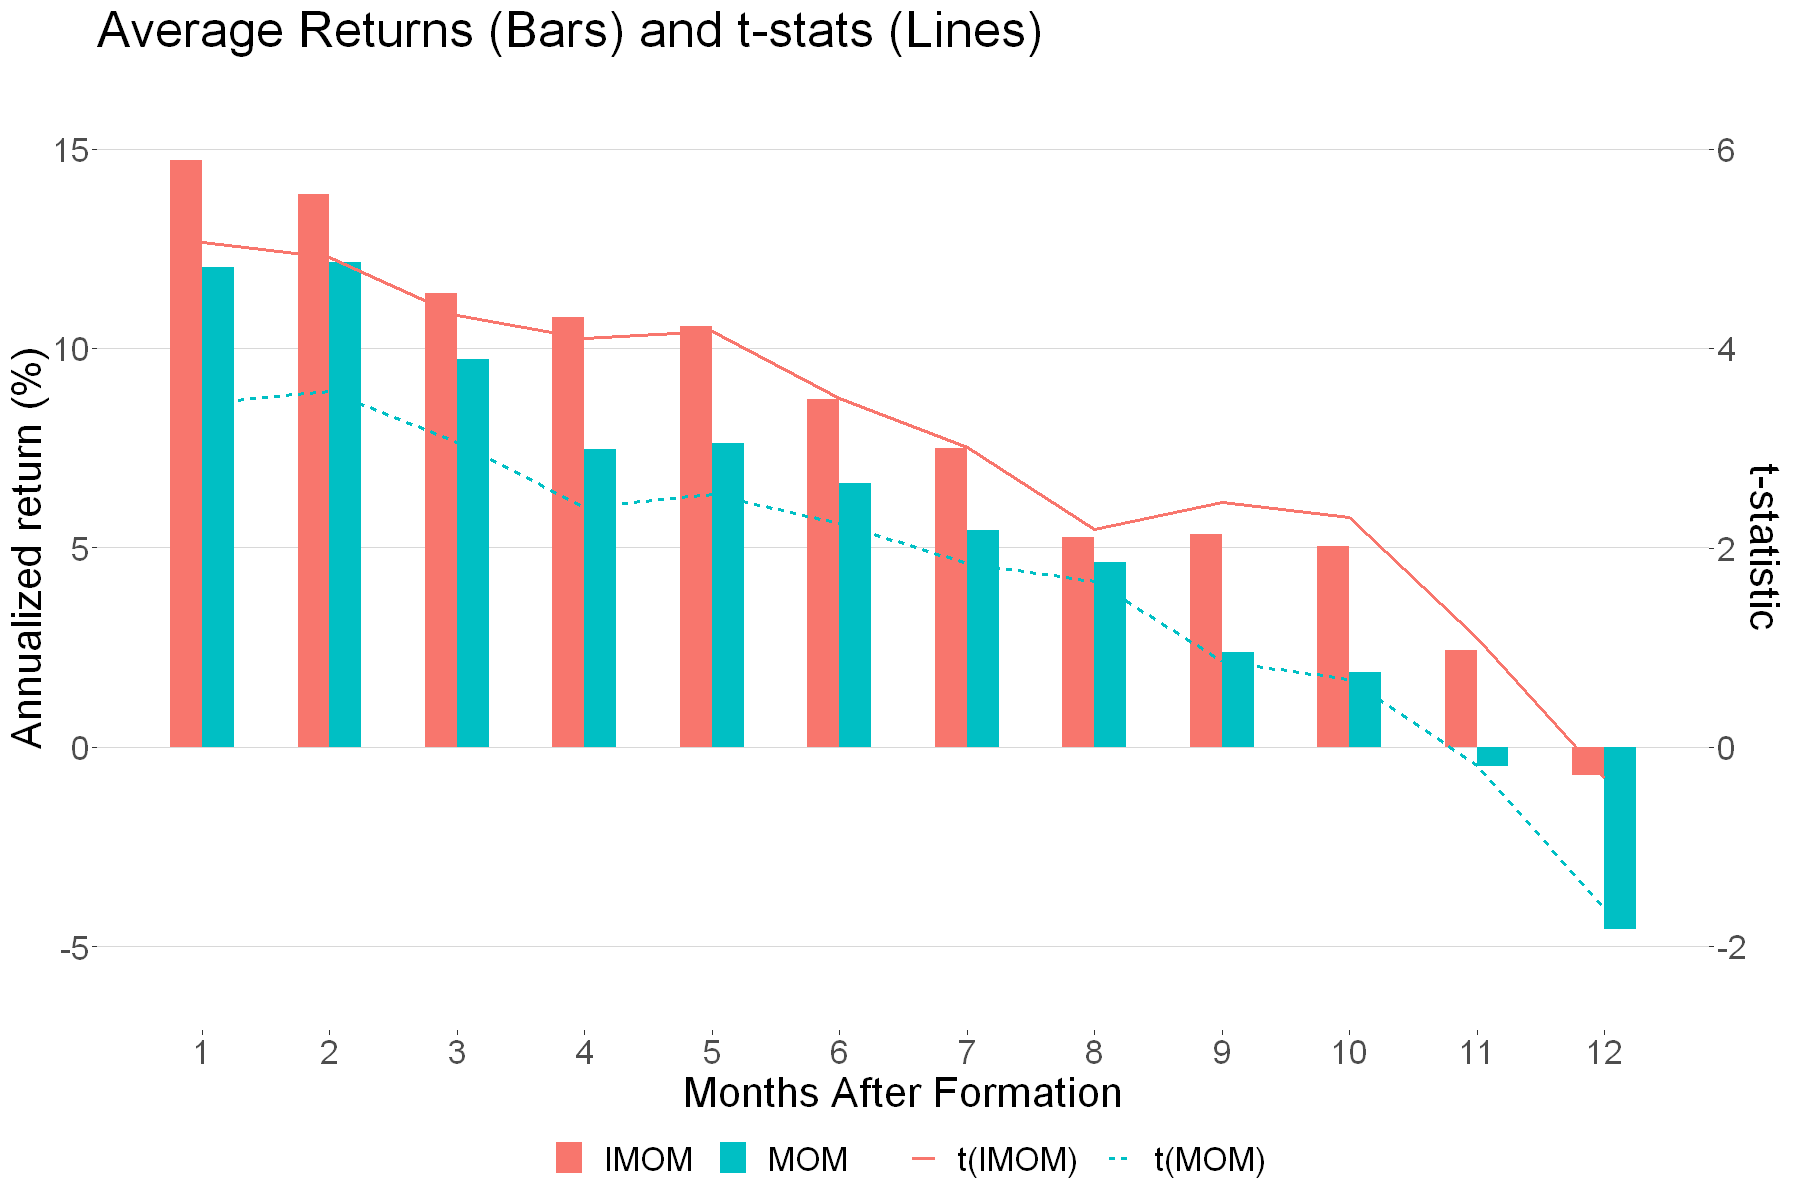

In [84]:
ggplot(data = figure_data_2, aes(x = month, y = value)) +
    geom_bar(aes(fill = variable), data = figure_data_2[type == "ret"], stat = "identity", 
             position = "dodge", width = 0.5) +
    
    geom_line(aes(y = value * 2.5, color = variable, linetype = variable), 
              data = figure_data_2[type == "t stat"], size = 1) +
    
    scale_y_continuous(sec.axis = sec_axis(~./2.5, name = "t-statistic",
                                           breaks = seq(-2, 8, 2)),
                       limits = c(-6, 16), breaks = seq(-5, 25, 5)) +
    scale_x_continuous(n.breaks = 12) +
    labs(
        x = "Months After Formation",
        y = "Annualized return (%)",
        colour = "",
        linetype = "",
        fill = ""
    ) +
    ggtitle("Average Returns (Bars) and t-stats (Lines)") +
    ggthemes::theme_hc(25)

## 6.2 alphas

In [85]:
idio_strategy_wml_roll12 = merge(idio_strategy_wml_roll12, ff_four, by = c("end_of_month"))
idio_strategy_wml_roll12 = merge(idio_strategy_wml_roll12, ff_five, all.x = TRUE, suffixes = c("", "_ff5"), by = c('end_of_month'))

mom_strategy_wml_roll12 = merge(mom_strategy_wml_roll12, ff_four, by = c("end_of_month"))
mom_strategy_wml_roll12 = merge(mom_strategy_wml_roll12, ff_five, all.x = TRUE, suffixes = c("", "_ff5"), by = c('end_of_month'))

In [86]:
ff_alpha_roll12 = function(inp_data, month) {
    
    lm_fit_4f = lm(get(paste0("wml_vw_", month)) ~ mkt_rf + smb + hml + mom, data = inp_data)
    lm_fit_5f = lm(get(paste0("wml_vw_", month)) ~ mkt_rf_ff5 + smb_ff5 + hml_ff5 + rmw + cma, data = inp_data)
    
    output = data.table(
        ff4_alpha = annualize_ret(lm_fit_4f$coefficients[1]),
        ff4_t = summary(lm_fit_4f)[["coefficients"]][1, "t value"],
        ff5_alpha = annualize_ret(lm_fit_5f$coefficients[1]),
        ff5_t = summary(lm_fit_5f)[["coefficients"]][1, "t value"]
    )
    
    return(output)
}

In [87]:
idio_ff_roll12 = data.table(month = 1, ff_alpha_roll12(idio_strategy_wml_roll12, 1))
for (i in 2:12) {
    idio_ff_roll12 = rbind(idio_ff_roll12, data.table(month = i, ff_alpha_roll12(idio_strategy_wml_roll12, i)))
}


mom_ff_roll12 = data.table(month = 1, ff_alpha_roll12(mom_strategy_wml_roll12, 1))
for (i in 2:12) {
    mom_ff_roll12 = rbind(mom_ff_roll12, data.table(month = i, ff_alpha_roll12(mom_strategy_wml_roll12, i)))
}

In [88]:
#Summary
roll_12_ff_summary = merge(idio_ff_roll12, mom_ff_roll12, 
                            suffixes = c("_IMOM", "_MOM"), by = c("month"))

In [89]:
figure_data_3 = roll_12_ff_summary[,c(1, 2:3, 6:7)]
names(figure_data_3)[2:5] = c("IMOM", "t(IMOM)", "MOM", "t(MOM)")

figure_data_3 = melt(figure_data_3, "month")
figure_data_3[, type := rep(c(rep("ret", 12), rep("t stat", 12)), 2)]

## Figure 2: Four factor alphas <a class="anchor" id="figure_2"></a>
Four-factor alphas (annualized, percent) and t-stats for the value-weighted long–short portfolio (WML) formed on
idiosyncratic momentum (IMOM) and traditional momentum (MOM) up to 12 months after formation

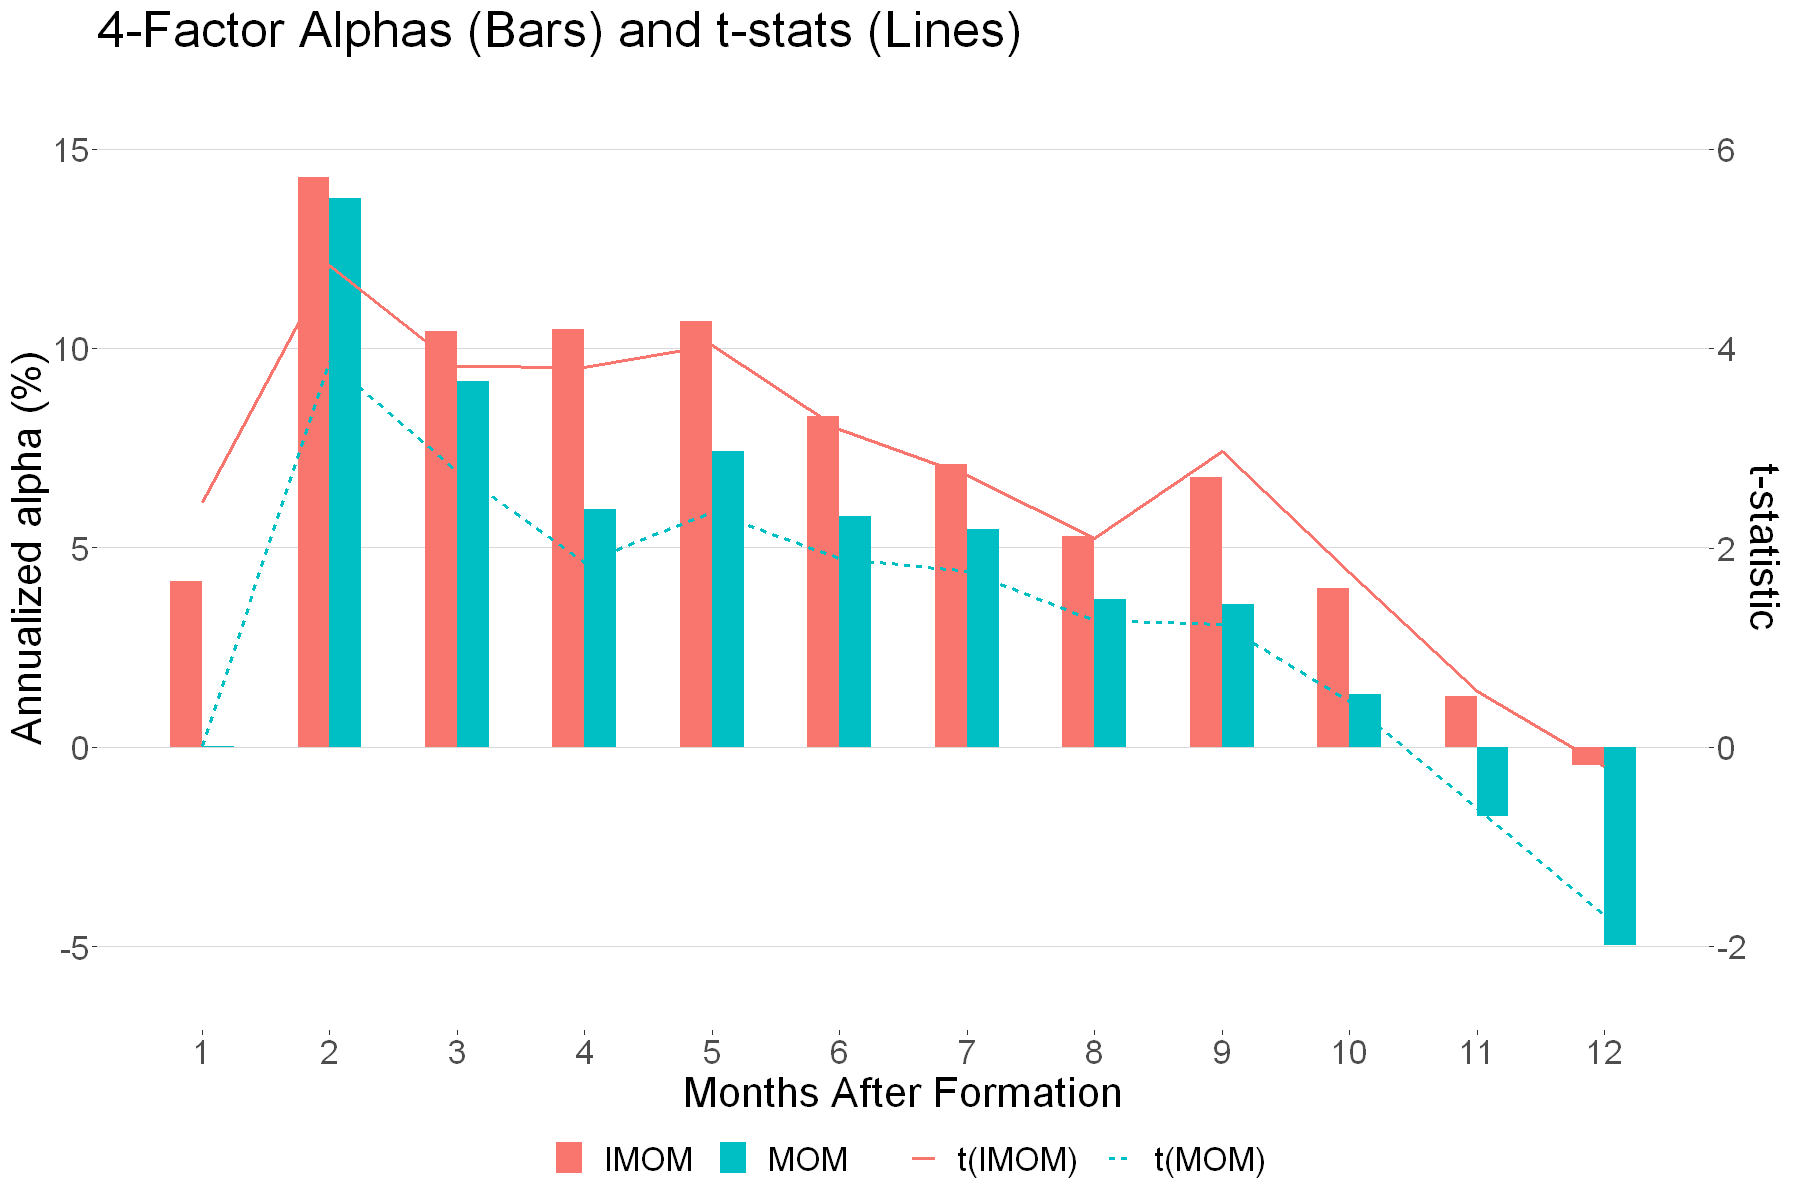

In [90]:
ggplot(data = figure_data_3, aes(x = month, y = value)) +
    geom_bar(aes(fill = variable), data = figure_data_3[type == "ret"], stat = "identity", 
             position = "dodge", width = 0.5) +
    
    geom_line(aes(y = value * 2.5, color = variable, linetype = variable), 
              data = figure_data_3[type == "t stat"], size = 1) +
    
    scale_y_continuous(sec.axis = sec_axis(~./2.5, name = "t-statistic",
                                           breaks = seq(-2, 8, 2)),
                       limits = c(-6, 16), breaks = seq(-5, 25, 5)) +
    scale_x_continuous(n.breaks = 12) +
    labs(
        x = "Months After Formation",
        y = "Annualized alpha (%)",
        colour = "",
        linetype = "",
        fill = ""
    ) +
    ggtitle("4-Factor Alphas (Bars) and t-stats (Lines)") +
    ggthemes::theme_hc(25)

## Figure 2.1: Five-factor alphas <a class="anchor" id="figure_2.1"></a>
Extend to 5-factor benchmarking

In [91]:
figure_data_4 = roll_12_ff_summary[,c(1, 4:5, 8:9)]
names(figure_data_4)[2:5] = c("IMOM", "t(IMOM)", "MOM", "t(MOM)")

figure_data_4 = melt(figure_data_4, "month")
figure_data_4[, type := rep(c(rep("ret", 12), rep("t stat", 12)), 2)]

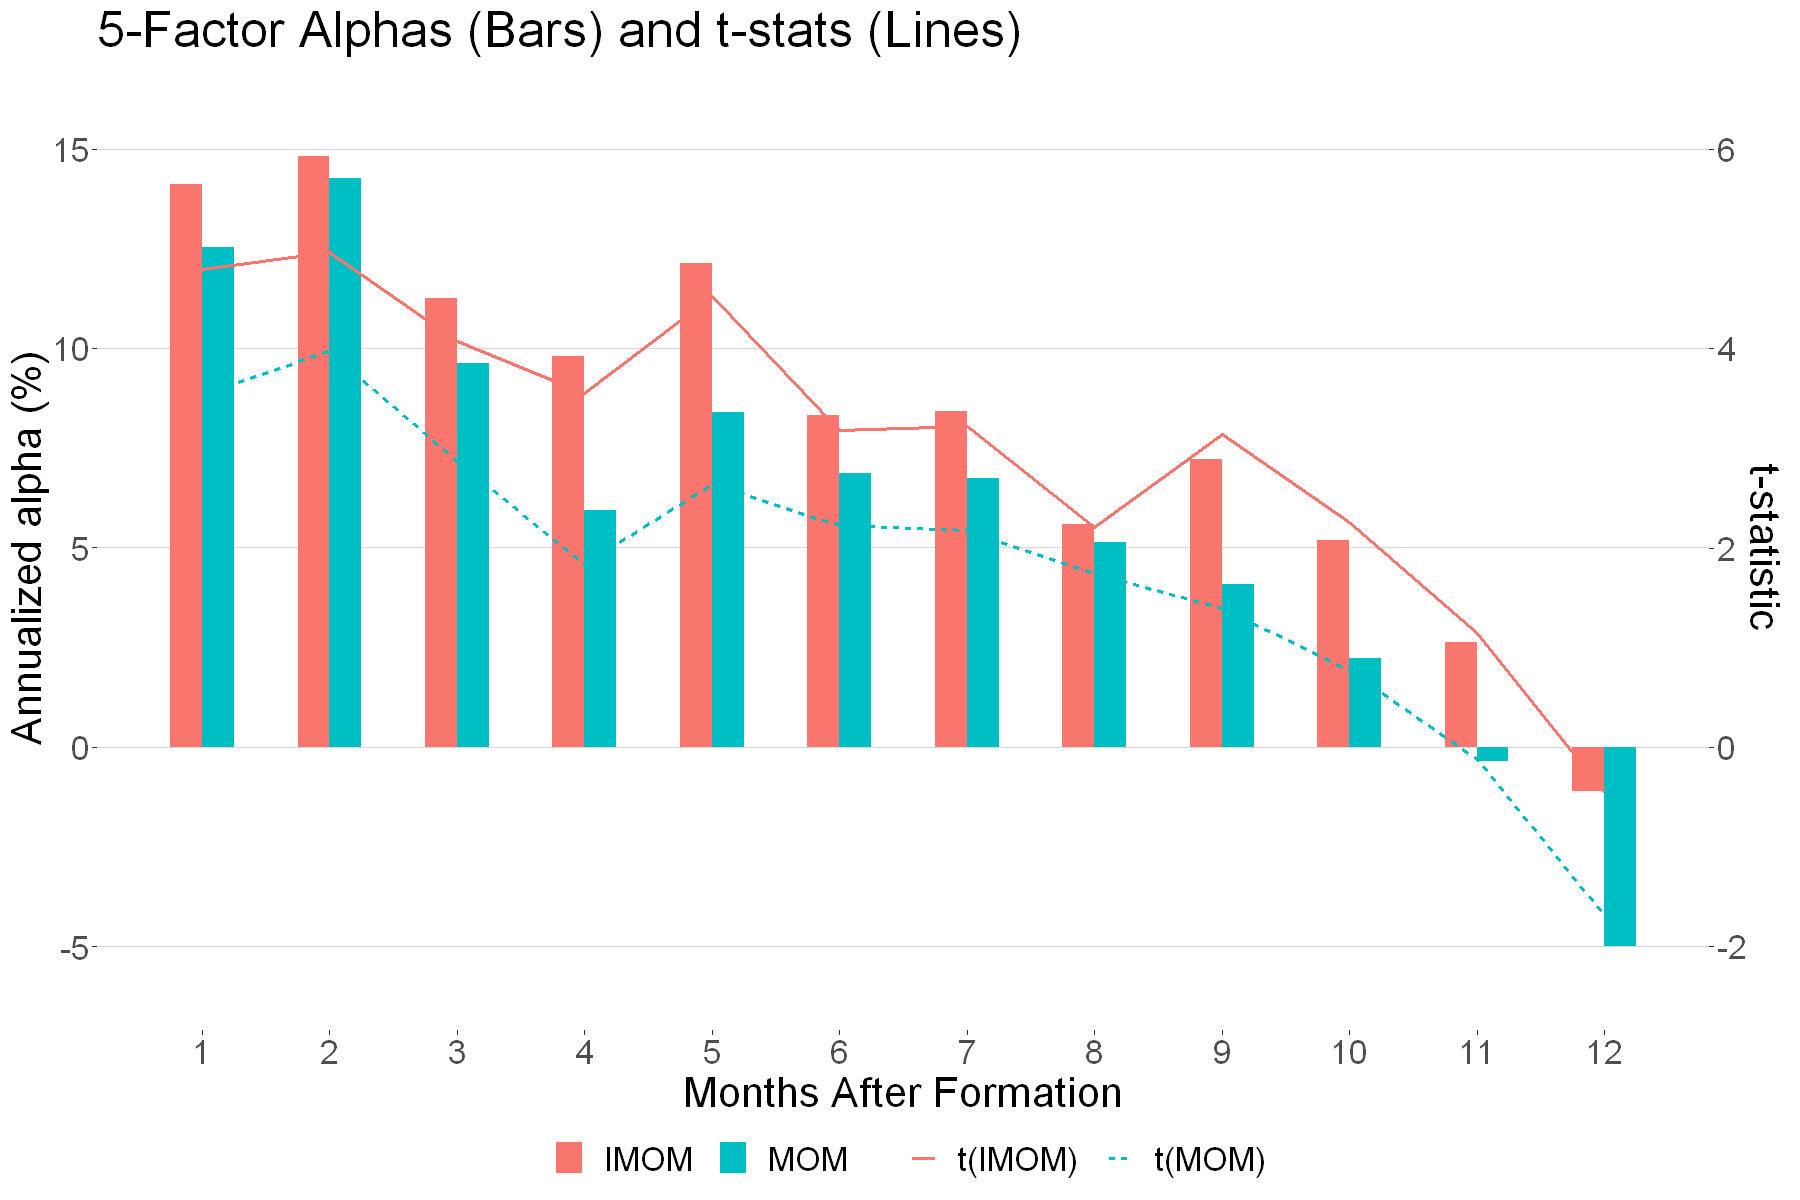

In [92]:
ggplot(data = figure_data_4, aes(x = month, y = value)) +
    geom_bar(aes(fill = variable), data = figure_data_4[type == "ret"], stat = "identity", 
             position = "dodge", width = 0.5) +
    
    geom_line(aes(y = value * 2.5, color = variable, linetype = variable), 
              data = figure_data_4[type == "t stat"], size = 1) +
    
    scale_y_continuous(sec.axis = sec_axis(~./2.5, name = "t-statistic",
                                           breaks = seq(-2, 8, 2)),
                       limits = c(-6, 16), breaks = seq(-5, 25, 5)) +
    scale_x_continuous(n.breaks = 12) +
    labs(
        x = "Months After Formation",
        y = "Annualized alpha (%)",
        colour = "",
        linetype = "",
        fill = ""
    ) +
    ggtitle("5-Factor Alphas (Bars) and t-stats (Lines)") +
    ggthemes::theme_hc(25)

# 7.  5 Factor Idiosyncratic Momentum <a class="anchor" id="bullet_7"></a>
This part extend the strategy to 5-factor excess returns


## 7.1 Build Signal

In [93]:
#Merge data
signal_5f = merge(msf, ff_four, all.x = TRUE, by = 'end_of_month')
signal_5f = merge(signal_5f, ff_five, all.x = TRUE, suffix = c("", "_5f"), by = c("end_of_month"))

In [94]:
#Calculate
signal_5f[, ret_rf := ret - rf_5f]
signal_5f[, mcap := abs(prc*shrout)]

In [95]:
idiosyncratic_return_5Factor = function(ret_rf, mkt_rf, smb, hml, rmw, cma){
    roll_width = 36  #12 for 1-year, 36 for 3-year
    
    if(length(ret_rf) < roll_width){
        return(NA)
    }
    
    ret_rf = ifelse(is.na(ret_rf), 0, ret_rf)
    
    fit_lm = roll_regres(ret_rf ~ mkt_rf + smb + hml + rmw + cma, width = roll_width)
    
    idio_ret = ret_rf - fit_lm$coefs[,1] 
        - fit_lm$coefs[,2] * mkt_rf
        - fit_lm$coefs[,3] * smb
        - fit_lm$coefs[,4] * hml
        - fit_lm$coefs[,5] * rmw
        - fit_lm$coefs[,5] * cma
    
    idio_ret = ifelse(idio_ret < -0.99, -0.99, idio_ret)
    
    return(idio_ret)
}

In [96]:
signal_5f = na.omit(signal_5f, cols = "ret_rf")

signal_5f[, idio_5f_ret := -1, by = permno]
signal_5f[, idio_5f_ret := idiosyncratic_return_5Factor(ret_rf, mkt_rf_5f, smb_5f, hml_5f, rmw, cma), by = permno]

In [97]:
#Create lag variables
setkey(signal_5f, permno, end_of_month)

#Misc
signal_5f[, prc_lag1 := shift(prc, n = 1, fill = NA, type = 'lag'), by = list(permno)]
signal_5f[, mcap_lag1 := shift(mcap, n = 1, fill = NA, type = 'lag'), by = list(permno)]
signal_5f[, ret_lag1 := shift(ret, n = 1, fill = NA, type = 'lag'), by = list(permno)]

#Rolling Sum
signal_5f[, roll_idio_5f_ret_11 := (roll_prod(1 + coalesce(idio_5f_ret, 0), n = 11, fill = NA, align = 'right')) - 1,
       by=list(permno)]

#Valid Observation
signal_5f[, rollvalidobs := (roll_sum( !is.na(idio_5f_ret), n = 12, fill = NA, align = 'right')), by = list(permno)]
signal_5f[, rollvalidret := (roll_sum( !is.na(ret_rf), n = 48, fill = NA, align = 'right')), by = list(permno)] 

signal_5f[, rollvalidobs_lag1 := shift(rollvalidobs, n = 1, fill = NA, type = 'lag'), by = list(permno)]
signal_5f[, rollvalidret_lag1 := shift(rollvalidret, n = 1, fill = NA, type = 'lag'), by = list(permno)]

#Signal
signal_5f[, IMOM_5F := shift(roll_idio_5f_ret_11, n = 2, fill = NA, type = 'lag'), by = list(permno)]

## 7.2 Build Portfolio

In [98]:
signal_5f_2 = copy(signal_5f) %>% 
    subset( !is.na(IMOM_5F) & 
            !is.na(ret_rf) &               # has return this month
            !is.na(mcap_lag1) &            # non missing market cap
            !is.na(prc_lag1)  &            # non missing price 
            rollvalidobs_lag1 >= 12 &      # full year of data
            #rollvalidret_lag1 >= 48 &      # full set of data for regression
            end_of_month >= SAMPLE_START_DATE &    
            end_of_month <= SAMPLE_END_DATE
    )

In [99]:
#Apply bins
signal_5f_2[, bin := apply_quantiles(IMOM_5F, bins = 5), by = end_of_month]

#Create profolio
IMOM_5f_portfolios = signal_5f_2[, .(
    ew = mean(ret_rf),
    vw = sum(ret_rf * mcap_lag1) / sum(mcap_lag1)
), by = .(end_of_month, bin)]

## 7.3 Summary

In [100]:
n = nrow(IMOM_5f_portfolios[, .N, by = end_of_month])

mean_ret_5f = IMOM_5f_portfolios[, 
    list(ew = mean(ew), 
        vw = mean(vw),
        ew_annual = annualize_ret(mean(ew)),
        vw_annual = annualize_ret(mean(vw)),
        sharpe_ew = mean(ew)/sd(ew) * sqrt(12),
        sharpe_vw = mean(vw)/sd(vw) * sqrt(12),
        ew_t = mean(ew)/sd(ew) * sqrt(n),
        vw_t = mean(vw)/sd(vw) * sqrt(n)
    ), 
    by = bin]

setkey(mean_ret_5f, bin)

strategy_wml_5f = merge(
    IMOM_5f_portfolios[bin==5,], IMOM_5f_portfolios[bin==1,], 
    suffixes=c('_long','_short'), 
    by = c('end_of_month')
)

strategy_wml_5f[, ew := (ew_long - ew_short)]
strategy_wml_5f[, vw := (vw_long - vw_short)]

strategy_wml_5f_summary = data.table(
    ew_mean = annualize_ret(mean(strategy_wml_5f$ew)),
    ew_sharpe = sharpe(strategy_wml_5f$ew) * sqrt(12),
    vw_mean = annualize_ret(mean(strategy_wml_5f$vw)),
    vw_sharpe = sharpe(strategy_wml_5f$vw) * sqrt(12),
    ew_t = sharpe(strategy_wml_5f$ew) * sqrt(n),
    vw_t = sharpe(strategy_wml_5f$vw) * sqrt(n)
)

In [101]:
x = data.table(portfolio = "vw", dcast(mean_ret_5f, 1 ~ bin, value.var = "ew_annual"))
x = rbind(x,data.table(portfolio = "ew", dcast(mean_ret_5f, 1 ~ bin, value.var = "vw_annual")))

y = data.table(portfolio = "vw", dcast(mean_ret_5f, 1 ~ bin, value.var = "ew_t"))
y = rbind(y,data.table(portfolio = "ew", dcast(mean_ret_5f, 1 ~ bin, value.var = "vw_t")))
names(y)[3:7] = paste0(names(y)[3:7], "_t")

z = data.table(portfolio = "ew", strategy_wml_5f_summary[, .(wml = ew_mean, wml_t = ew_t)])
z = rbind(z, data.table(portfolio = "vw", strategy_wml_5f_summary[, .(wml = vw_mean, wml_t = vw_t)]))

wml_summary_5f = merge(x[,-2], y[,-2], keyby = c("portfolio"))
wml_summary_5f = merge(wml_summary_5f, z, keyby = c("portfolio"))

wml_summary_5f_output = data.table(t(lapply(wml_summary_5f[1, .SD, .SDcol = -grep("_t", names(wml_summary))], round_num)))
for(i in 1:3){
    if(i %% 2 == 0){
        wml_summary_5f_output = rbind(wml_summary_5f_output, lapply(wml_summary_5f[i%/%2+1, .SD, .SDcol = -grep("_t", names(wml_summary))],round_num), use.names = FALSE)
    } else {
        wml_summary_5f_output = rbind(wml_summary_5f_output, lapply(wml_summary_5f[i%/%2+1, .(NA, .SD), .SDcol = c(grep("_t", names(wml_summary)))], add_bracket), use.names = FALSE)
    }
}

## Table 8.1: Five-factor IMOM Summary <a class="anchor" id="table_8.1"></a>

In [102]:
IRdisplay::display_html(
        paste(capture.output(
            stargazer(wml_summary_5f_output, type = "html", summary = FALSE, rownames = FALSE)
        ),
        collapse='', sep='')
)


portfolio 1 2 3 4 5 wml ew -1.86 4.13 5.21 7.23 10.77 10.19 (-0.49) (1.46) (2.13) (2.94) (3.64) (3.58) vw 5.87 7.59 10.18 12.05 16.6 12.85 (1.32) (2.39) (3.63) (4.27) (4.68) (3.98)

In [103]:
stargazer(wml_summary_5f_output, type = "latex", summary = FALSE, rownames = FALSE)


% Table created by stargazer v.5.2.2 by Marek Hlavac, Harvard University. E-mail: hlavac at fas.harvard.edu
% Date and time: Wed, May 06, 2020 - 12:07:31 AM
\begin{table}[!htbp] \centering 
  \caption{} 
  \label{} 
\begin{tabular}{@{\extracolsep{5pt}} ccccccc} 
\\[-1.8ex]\hline 
\hline \\[-1.8ex] 
portfolio & 1 & 2 & 3 & 4 & 5 & wml \\ 
\hline \\[-1.8ex] 
ew & -1.86 & 4.13 & 5.21 & 7.23 & 10.77 & 10.19 \\ 
 & (-0.49) & (1.46) & (2.13) & (2.94) & (3.64) & (3.58) \\ 
vw & 5.87 & 7.59 & 10.18 & 12.05 & 16.6 & 12.85 \\ 
 & (1.32) & (2.39) & (3.63) & (4.27) & (4.68) & (3.98) \\ 
\hline \\[-1.8ex] 
\end{tabular} 
\end{table} 


## 7.4 Alpha, Fema French benchmarking

In [104]:
strategy_wml_5f = merge(strategy_wml_5f, ff_four, all.x = TRUE, by = c('end_of_month'))

ew_lm_fit_capm = lm(ew ~ mkt_rf, data = strategy_wml_5f)
ew_lm_fit_3f = lm(ew ~ mkt_rf + smb + hml, data = strategy_wml_5f)
ew_lm_fit_4f = lm(ew ~ mkt_rf + smb + hml + mom, data = strategy_wml_5f)

summary(ew_lm_fit_capm)
summary(ew_lm_fit_3f)
summary(ew_lm_fit_4f)


vw_lm_fit_capm = lm(vw ~ mkt_rf, data = strategy_wml_5f)
vw_lm_fit_3f = lm(vw ~ mkt_rf + smb + hml, data = strategy_wml_5f)
vw_lm_fit_4f = lm(vw ~ mkt_rf + smb + hml + mom, data = strategy_wml_5f)

summary(vw_lm_fit_capm)
summary(vw_lm_fit_3f)
summary(vw_lm_fit_4f)


#Five factor benchmarking
strategy_wml_5f = merge(strategy_wml_5f, ff_five, all.x = TRUE, suffixes = c("", "_ff5"), by = c('end_of_month'))

ew_lm_fit_5f = lm(ew ~ mkt_rf_ff5 + smb_ff5 + hml_ff5 + rmw + cma, data = strategy_wml_5f)
vw_lm_fit_5f = lm(vw ~ mkt_rf_ff5 + smb_ff5 + hml_ff5 + rmw + cma, data = strategy_wml_5f)

summary(ew_lm_fit_5f)
summary(vw_lm_fit_5f)


Call:
lm(formula = ew ~ mkt_rf, data = strategy_wml_5f)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.51841 -0.01547  0.00315  0.02278  0.16261 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.009063   0.002231   4.062 5.60e-05 ***
mkt_rf      -0.233015   0.048095  -4.845 1.67e-06 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.05126 on 530 degrees of freedom
Multiple R-squared:  0.04241,	Adjusted R-squared:  0.0406 
F-statistic: 23.47 on 1 and 530 DF,  p-value: 1.666e-06



Call:
lm(formula = ew ~ mkt_rf + smb + hml, data = strategy_wml_5f)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.51279 -0.01483  0.00343  0.02146  0.17594 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.009068   0.002268   3.999 7.28e-05 ***
mkt_rf      -0.211060   0.052203  -4.043 6.06e-05 ***
smb         -0.094738   0.073639  -1.287    0.199    
hml          0.008524   0.079814   0.107    0.915    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.05128 on 528 degrees of freedom
Multiple R-squared:  0.04556,	Adjusted R-squared:  0.04014 
F-statistic: 8.402 on 3 and 528 DF,  p-value: 1.831e-05



Call:
lm(formula = ew ~ mkt_rf + smb + hml + mom, data = strategy_wml_5f)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.283242 -0.012569  0.002232  0.016222  0.098361 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) -0.0001737  0.0013071  -0.133  0.89435    
mkt_rf       0.0057105  0.0301147   0.190  0.84968    
smb         -0.1224881  0.0415082  -2.951  0.00331 ** 
hml          0.2912743  0.0457560   6.366 4.23e-10 ***
mom          0.9950830  0.0295304  33.697  < 2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.0289 on 527 degrees of freedom
Multiple R-squared:  0.6974,	Adjusted R-squared:  0.6952 
F-statistic: 303.7 on 4 and 527 DF,  p-value: < 2.2e-16



Call:
lm(formula = vw ~ mkt_rf, data = strategy_wml_5f)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.33150 -0.02459  0.00332  0.03174  0.17862 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.011535   0.002457   4.695 3.40e-06 ***
mkt_rf      -0.348652   0.052963  -6.583 1.11e-10 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.05645 on 530 degrees of freedom
Multiple R-squared:  0.07558,	Adjusted R-squared:  0.07384 
F-statistic: 43.34 on 1 and 530 DF,  p-value: 1.111e-10



Call:
lm(formula = vw ~ mkt_rf + smb + hml, data = strategy_wml_5f)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.32688 -0.02463  0.00362  0.03165  0.16704 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.010688   0.002493   4.288 2.14e-05 ***
mkt_rf      -0.330608   0.057377  -5.762 1.41e-08 ***
smb          0.062155   0.080938   0.768   0.4429    
hml          0.164492   0.087725   1.875   0.0613 .  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.05636 on 528 degrees of freedom
Multiple R-squared:  0.08213,	Adjusted R-squared:  0.07691 
F-statistic: 15.75 on 3 and 528 DF,  p-value: 8.025e-10



Call:
lm(formula = vw ~ mkt_rf + smb + hml + mom, data = strategy_wml_5f)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.146109 -0.015075  0.000946  0.014972  0.095371 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) -5.046e-05  1.241e-03  -0.041  0.96759    
mkt_rf      -7.873e-02  2.860e-02  -2.753  0.00611 ** 
smb          2.991e-02  3.942e-02   0.759  0.44830    
hml          4.930e-01  4.345e-02  11.347  < 2e-16 ***
mom          1.156e+00  2.804e-02  41.230  < 2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.02744 on 527 degrees of freedom
Multiple R-squared:  0.7828,	Adjusted R-squared:  0.7811 
F-statistic: 474.8 on 4 and 527 DF,  p-value: < 2.2e-16



Call:
lm(formula = ew ~ mkt_rf_ff5 + smb_ff5 + hml_ff5 + rmw + cma, 
    data = strategy_wml_5f)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.46417 -0.01616  0.00187  0.02211  0.18704 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.005526   0.002276   2.428  0.01551 *  
mkt_rf_ff5  -0.097019   0.054442  -1.782  0.07532 .  
smb_ff5     -0.011846   0.075015  -0.158  0.87458    
hml_ff5     -0.286114   0.104937  -2.727  0.00661 ** 
rmw          0.495039   0.102847   4.813 1.94e-06 ***
cma          0.661693   0.155394   4.258 2.44e-05 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.0497 on 526 degrees of freedom
Multiple R-squared:  0.1067,	Adjusted R-squared:  0.09818 
F-statistic: 12.56 on 5 and 526 DF,  p-value: 1.539e-11



Call:
lm(formula = vw ~ mkt_rf_ff5 + smb_ff5 + hml_ff5 + rmw + cma, 
    data = strategy_wml_5f)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.314811 -0.024950  0.005194  0.029929  0.198675 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.007223   0.002519   2.868  0.00430 ** 
mkt_rf_ff5  -0.223493   0.060256  -3.709  0.00023 ***
smb_ff5      0.165409   0.083026   1.992  0.04686 *  
hml_ff5     -0.151949   0.116144  -1.308  0.19135    
rmw          0.478626   0.113831   4.205 3.07e-05 ***
cma          0.662930   0.171990   3.854  0.00013 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.05501 on 526 degrees of freedom
Multiple R-squared:  0.1288,	Adjusted R-squared:  0.1206 
F-statistic: 15.56 on 5 and 526 DF,  p-value: 2.735e-14


In [105]:
wml_5f_factor_summary = data.table(
    portfolio = character(), 
    alpha = numeric(), mkt = numeric(), smb = numeric(), hml = numeric(), 
    umd = numeric(), rmw = numeric(), cma = numeric(), 
    alpha_t = numeric(), mkt_t = numeric(), smb_t = numeric(), hml_t = numeric(), 
    umd_t = numeric(), rmw_t = numeric(), cma_t = numeric(), 
    r_squared = numeric()
)

wml_5f_factor_summary = rbind(wml_5f_factor_summary, summerize_wml_factors(ew_lm_fit_capm, "ew"), use.names = FALSE)
wml_5f_factor_summary = rbind(wml_5f_factor_summary, summerize_wml_factors(ew_lm_fit_3f, "ew"), use.names = FALSE)
wml_5f_factor_summary = rbind(wml_5f_factor_summary, summerize_wml_factors(ew_lm_fit_4f, "ew"), use.names = FALSE)
wml_5f_factor_summary = rbind(wml_5f_factor_summary, summerize_wml_factors(ew_lm_fit_5f, "ew"), use.names = FALSE)
wml_5f_factor_summary = rbind(wml_5f_factor_summary, summerize_wml_factors(vw_lm_fit_capm, "vw"), use.names = FALSE)
wml_5f_factor_summary = rbind(wml_5f_factor_summary, summerize_wml_factors(vw_lm_fit_3f, "vw"), use.names = FALSE)
wml_5f_factor_summary = rbind(wml_5f_factor_summary, summerize_wml_factors(vw_lm_fit_4f, "vw"), use.names = FALSE)
wml_5f_factor_summary = rbind(wml_5f_factor_summary, summerize_wml_factors(vw_lm_fit_5f, "vw"), use.names = FALSE)

In [106]:
wml_5f_factor_summary_output = data.table(t(lapply(wml_5f_factor_summary[1, .SD, .SDcol = -grep("_t", names(wml_5f_factor_summary))], round_num)))
for(i in 1:15){
    if(i %% 2 == 0){
        wml_5f_factor_summary_output = rbind(wml_5f_factor_summary_output, lapply(wml_5f_factor_summary[i%/%2+1, .SD, .SDcol = -grep("_t", names(wml_5f_factor_summary))],round_num), use.names = FALSE)
    } else {
        wml_5f_factor_summary_output = rbind(wml_5f_factor_summary_output, lapply(wml_5f_factor_summary[i%/%2+1, .(NA, .SD, NA), .SDcol = c(grep("_t", names(wml_5f_factor_summary)))], add_bracket), use.names = FALSE)
    }
}

## Table 8.2: Five-factor IMOM Factor Regresssion <a class="anchor" id="table_8.2"></a>

In [107]:
IRdisplay::display_html(
        paste(capture.output(
            stargazer(wml_5f_factor_summary_output, type = "html", summary = FALSE, rownames = FALSE)
        ),
        collapse='', sep='')
)


portfolio alpha mkt smb hml umd rmw cma r_squared ew 11.43 -0.23 0.04 (4.06) (-4.84) ew 11.44 -0.21 -0.09 0.01 0.05 (4) (-4.04) (-1.29) (0.11) ew -0.21 0.01 -0.12 0.29 1 0.7 (-0.13) (0.19) (-2.95) (6.37) (33.7) ew 6.84 -0.1 -0.01 -0.29 0.5 0.66 0.11 (2.43) (-1.78) (-0.16) (-2.73) (4.81) (4.26) vw 14.76 -0.35 0.08 (4.7) (-6.58) vw 13.61 -0.33 0.06 0.16 0.08 (4.29) (-5.76) (0.77) (1.88) vw -0.06 -0.08 0.03 0.49 1.16 0.78 (-0.04) (-2.75) (0.76) (11.35) (41.23) vw 9.02 -0.22 0.17 -0.15 0.48 0.66 0.13 (2.87) (-3.71) (1.99) (-1.31) (4.2) (3.85)

In [108]:
stargazer(wml_5f_factor_summary_output, type = "latex", summary = FALSE, rownames = FALSE)


% Table created by stargazer v.5.2.2 by Marek Hlavac, Harvard University. E-mail: hlavac at fas.harvard.edu
% Date and time: Wed, May 06, 2020 - 12:07:33 AM
\begin{table}[!htbp] \centering 
  \caption{} 
  \label{} 
\begin{tabular}{@{\extracolsep{5pt}} ccccccccc} 
\\[-1.8ex]\hline 
\hline \\[-1.8ex] 
portfolio & alpha & mkt & smb & hml & umd & rmw & cma & r\_squared \\ 
\hline \\[-1.8ex] 
ew & 11.43 & -0.23 &  &  &  &  &  & 0.04 \\ 
 & (4.06) & (-4.84) &  &  &  &  &  &  \\ 
ew & 11.44 & -0.21 & -0.09 & 0.01 &  &  &  & 0.05 \\ 
 & (4) & (-4.04) & (-1.29) & (0.11) &  &  &  &  \\ 
ew & -0.21 & 0.01 & -0.12 & 0.29 & 1 &  &  & 0.7 \\ 
 & (-0.13) & (0.19) & (-2.95) & (6.37) & (33.7) &  &  &  \\ 
ew & 6.84 & -0.1 & -0.01 & -0.29 &  & 0.5 & 0.66 & 0.11 \\ 
 & (2.43) & (-1.78) & (-0.16) & (-2.73) &  & (4.81) & (4.26) &  \\ 
vw & 14.76 & -0.35 &  &  &  &  &  & 0.08 \\ 
 & (4.7) & (-6.58) &  &  &  &  &  &  \\ 
vw & 13.61 & -0.33 & 0.06 & 0.16 &  &  &  & 0.08 \\ 
 & (4.29) & (-5.76) & (0.77) & (1

## 7.5 P/L Curve

In [109]:
#P&L curve
strategy_wml_5f[, cum_ew := cumprod(1 + ew + rf) - 1]
strategy_wml_5f[, cum_vw := cumprod(1 + vw + rf) - 1]
strategy_wml_5f[, cum_mkt := cumprod(1 + mkt_rf + rf) - 1]

figure_data_5 = strategy_wml_5f[,.(end_of_month, cum_ew, cum_vw)]
names(figure_data_5)[2:3] = c("Equal Weighted", "Value Weighted")

figure_data_5 = melt(figure_data_5, id.vars = c("end_of_month"))
figure_data_5[, value := (value + 1)]

## Figure 4.1: Five-factor IMOM P/L Curve <a class="anchor" id="figure_4.1"></a>

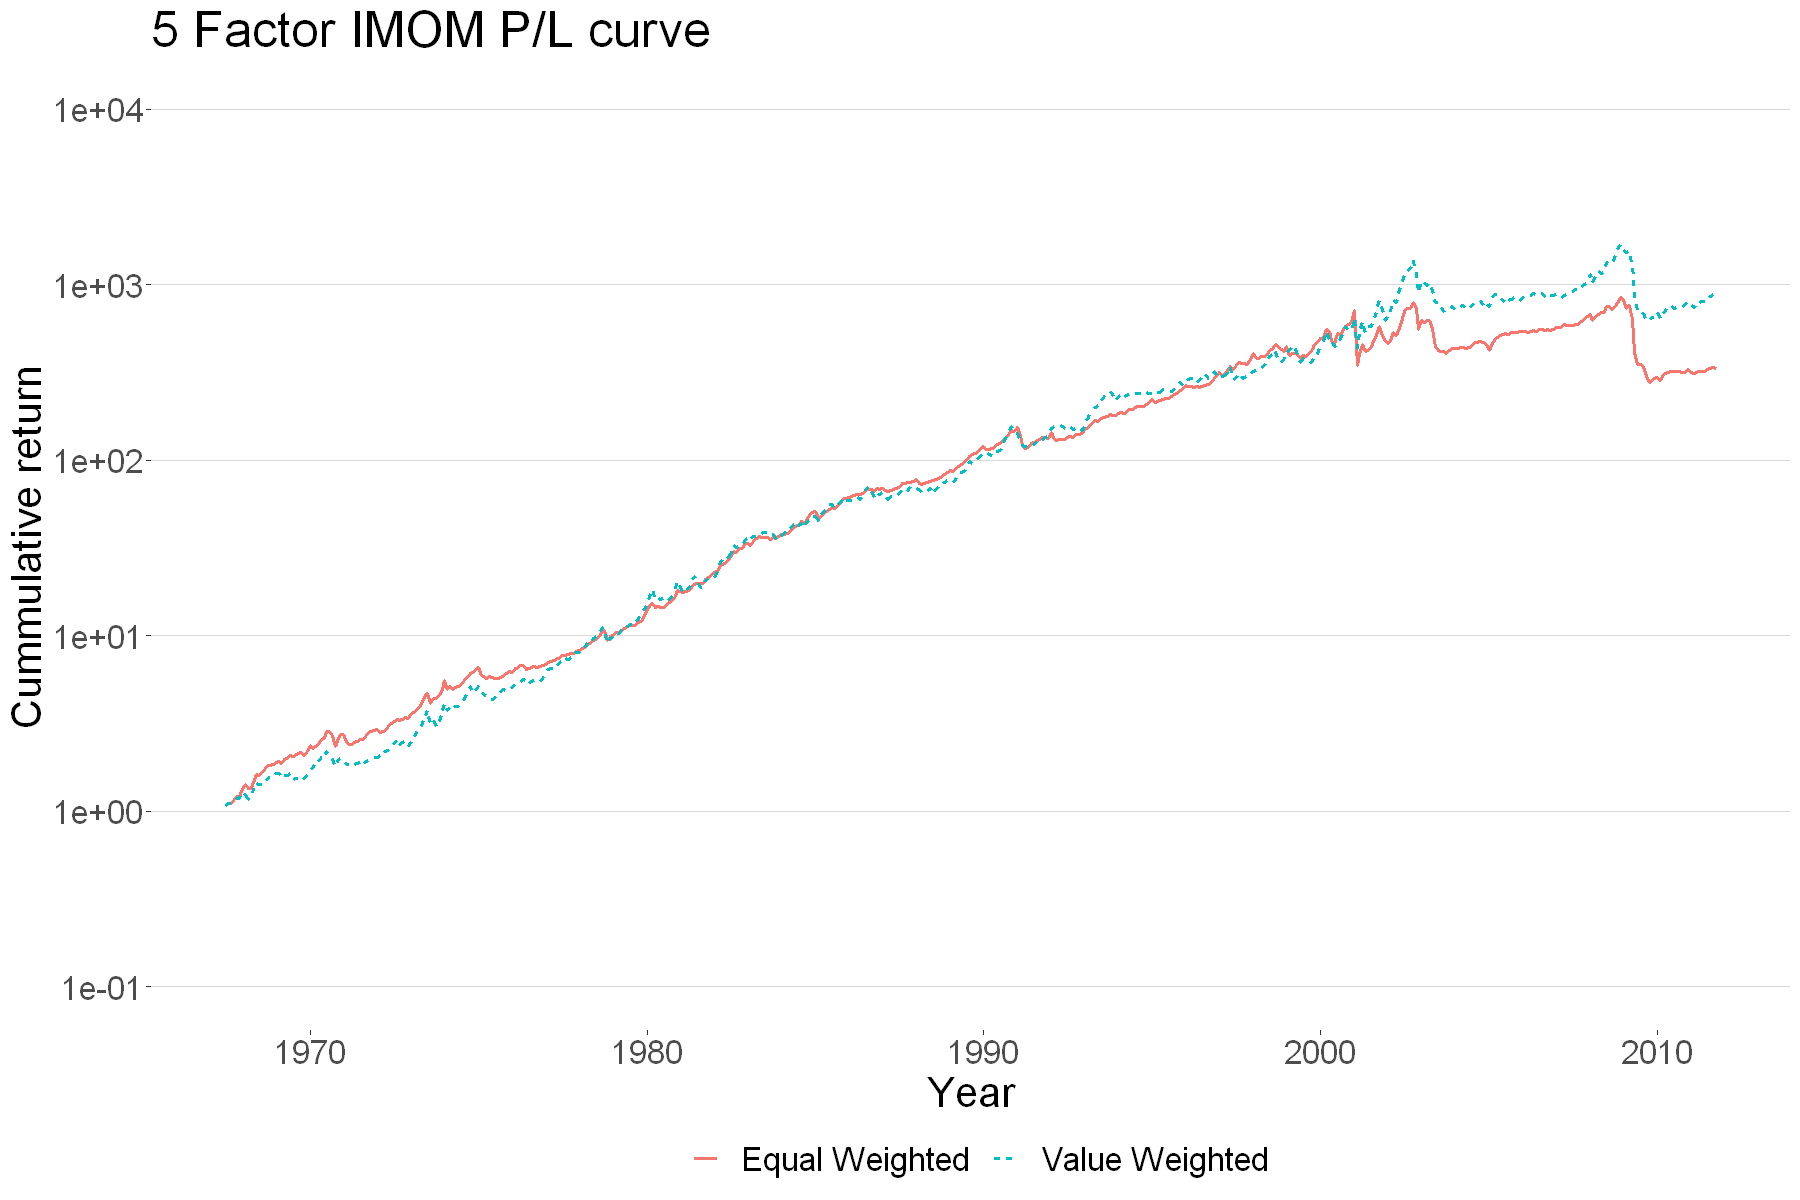

In [110]:
ggplot(data = figure_data_5, aes(x = as.Date(end_of_month), y = value, color = variable, linetype = variable)) +
    geom_line(size = 1) +
    labs(
        x = "Year",
        y = "Cummulative return",
        colour = "",
        linetype = ""
    ) +
    scale_y_log10(limit = c(1e-1, 1e04), n.breaks = 6) + ggtitle("5 Factor IMOM P/L curve") +
    ggthemes::theme_hc(25)

In [111]:
strategy_wml_5f[, cum_ew_long := cumprod(1 + ew_long + rf) - 1]
strategy_wml_5f[, cum_vw_long := cumprod(1 + vw_long + rf) - 1]
strategy_wml_5f[, cum_ew_short := cumprod(1 + ew_short + rf) - 1]
strategy_wml_5f[, cum_vw_short := cumprod(1 + vw_short + rf) - 1]
strategy_wml_5f[, cum_mkt := cumprod(1 + mkt_rf + rf) - 1]

In [112]:
figure_data_6 = merge(
    strategy_wml_5f , strategy_wml,
    suffixes=c('_IMOM_5f','_IMOM'),
    by = c('end_of_month')
)
setDT(figure_data_6)

figure_data_6[, cum_vw_long_IMOM_2 := cumprod(1 + vw_long_IMOM + rf_IMOM) - 1]
figure_data_6[, cum_vw_short_IMOM_2 := cumprod(1 + vw_short_IMOM + rf_IMOM) - 1]

In [113]:
figure_data_6 = figure_data_6[,c(
    "end_of_month",
    "cum_vw_long_IMOM_5f",
    "cum_vw_short_IMOM_5f",
    "cum_vw_long_IMOM_2",
    "cum_vw_short_IMOM_2",
    "cum_mkt_IMOM_5f"
    )]

names(figure_data_6)[2:6] = c("5 Factor IMOM (Long)", "5 Factor IMOM (Short)", "IMOM (Long)", "IMOM (Short)", "Market")

figure_data_6 = melt(figure_data_6, id.vars = c("end_of_month"))
figure_data_6[, value := (value + 1)]

## Figure 4.2: Five-factor IMOM Cummulative Performance <a class="anchor" id="figure_4.2"></a>

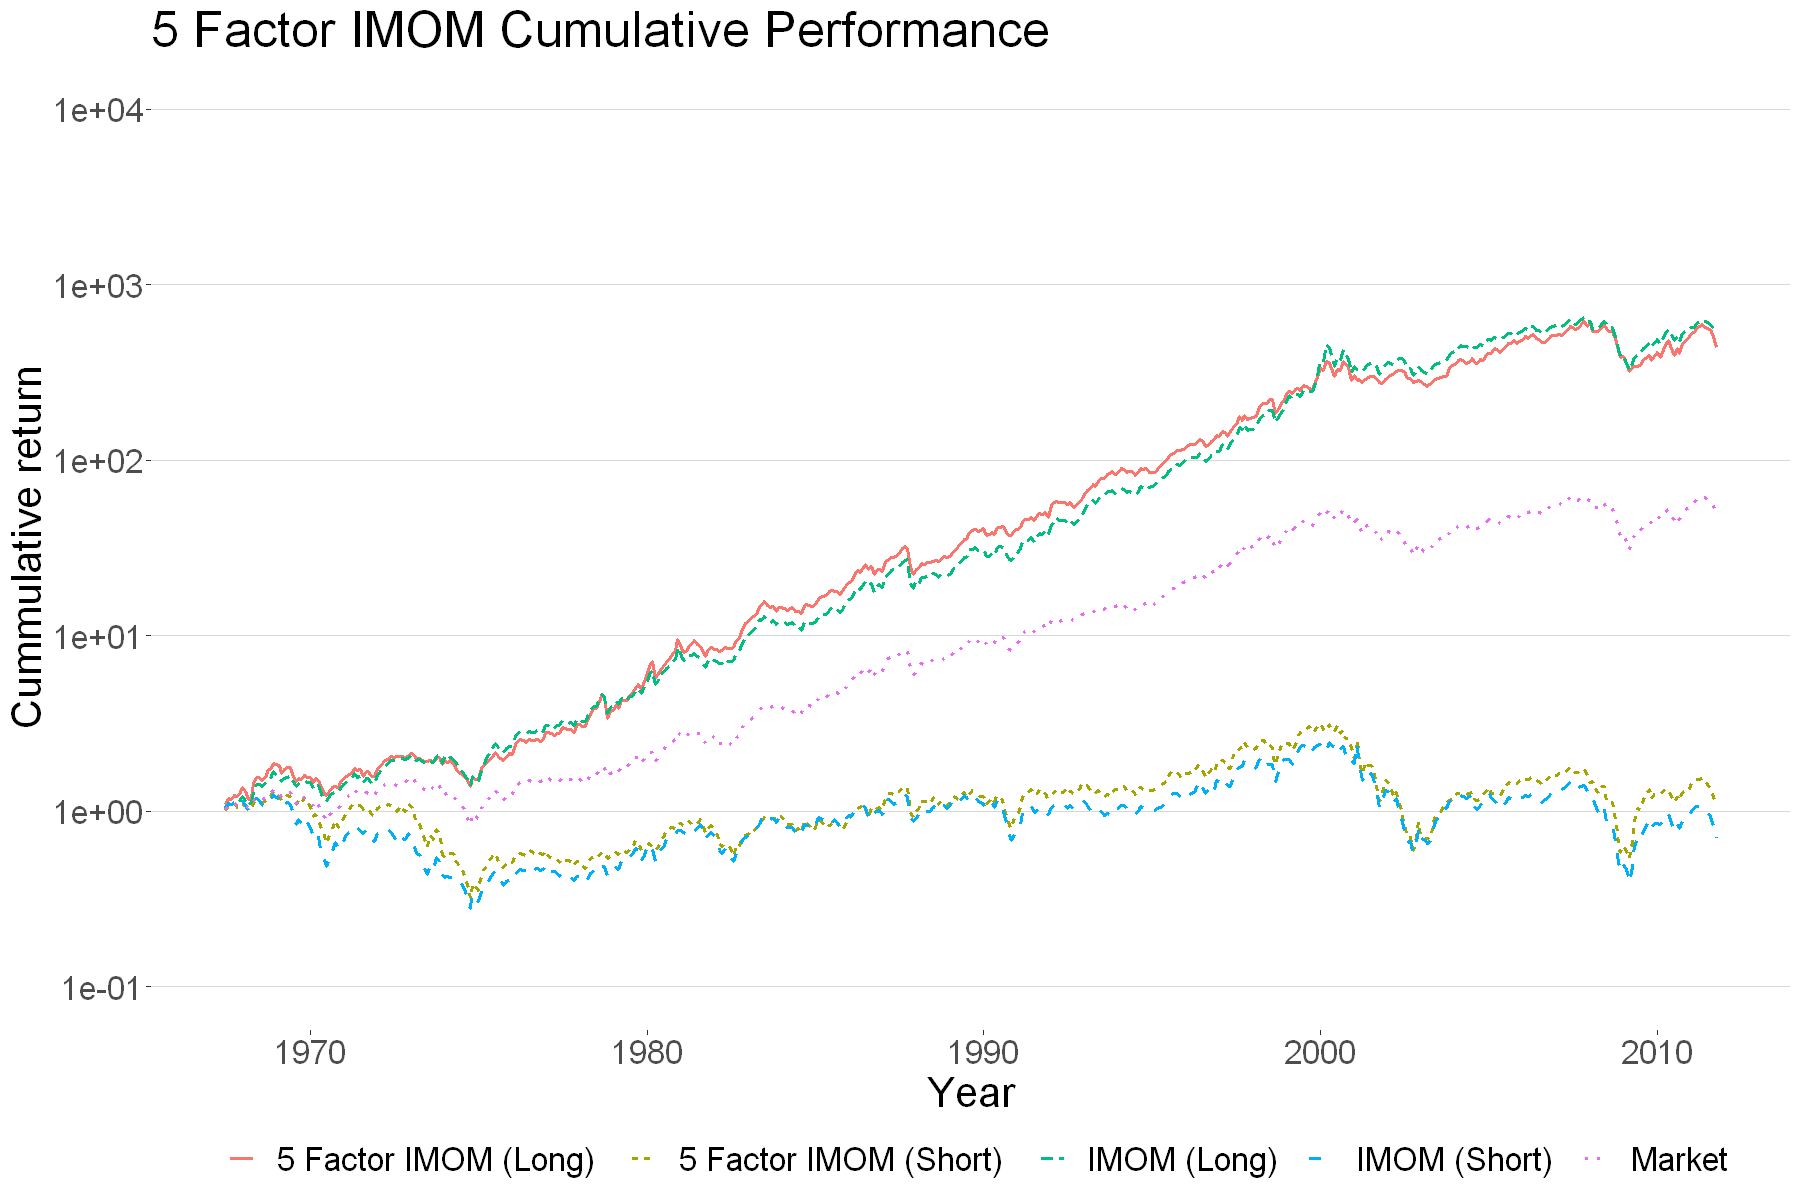

In [114]:
ggplot(data = figure_data_6, aes(x = as.Date(end_of_month), y = value, color = variable, linetype = variable)) +
    geom_line(size = 1) +
    labs(
        x = "Year",
        y = "Cummulative return",
        colour = "",
        linetype = ""
    ) +
    scale_y_log10(limit = c(1e-1, 1e04), n.breaks = 6) + ggtitle("5 Factor IMOM Cumulative Performance") +
    ggthemes::theme_hc(25)